# Промышленность. Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных
Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Исследовательский анализ данных

Датафреймы рассматриваются в порядке технологического процесса.
1. Подогрев расплавленной стали в ковше до нужной температуры графитовыми электродами: data_arc.csv — данные об электродах.
2. Легирование стали двумя способами: а) подача кусков сплава из бункера для сыпучих материалов (data_bulk.csv — данные о подаче сыпучих материалов (объём), data_bulk_time.csv — данные о подаче сыпучих материалов (время)), б) подача проволоки через специальный трайб-аппарат (data_wire.csv — данные о проволочных материалах (объём), data_wire_time.csv — данные о проволочных материалах (время)).
3. Продувание сплава инертным газом: data_gas.csv — данные о продувке сплава газом.
4. Измерения температуры: data_temp.csv — результаты измерения температуры.

In [1]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# открытие файлов
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
df_bulk_vol = pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
df_wire_vol = pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

# функция для изучения данных каждого датафрейма
def open_info(data):
    # вывод 5 строк данных
    print('*******************************************************')
    print('Представление датафрейма')
    display(data.head())
    print('*******************************************************')
    # вывод информации о датафрейме
    print('Общая информация о датафрейме')
    print('')
    print(data.info())
    print('*******************************************************')
    # вывод информации о распределении данных
    print('Распределение данных')
    display(data.describe())
    print('*******************************************************')
    # проверка на наличие дубликатов
    print('Дубликаты:', data.duplicated().sum())
    print('*******************************************************')
    # проверка на наличие пропусков
    print('Пропуски:', data.isnull().sum())
    


#### Данные об электродах (df_arc)

##### Общие сведения

In [2]:
open_info(df_arc)

*******************************************************
Представление датафрейма


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


*******************************************************
Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
*******************************************************
Распределение данных


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


*******************************************************
Дубликаты: 0
*******************************************************
Пропуски: key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


В датафрейме 14876 строк и 5 столбцов: номер партии, начало нагрева дуги, конец нагрева дуги, активная мощность, реактивная мощность. Дубликатов и пропусков нет.

Смущает наличие разнотипных названий столбцов и аномальное значение в столбце "Реактивная мощность".

Посмотрим, сколько всего партий представлено в датасете.

##### Данные по key

In [3]:
# количество партий
display(len(df_arc['key'].unique()))

df_arc['key'].value_counts()

3214

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

3214 партий. Это количество не совпадает с максимальным показателем столбца 'key'. Видим, что часть партий имеет несколько измерений мощности, поэтому в ряде строк повторяется номер партии.

In [4]:
# срез по значению 2108 в столбце key
df_arc.query('key == 2108')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9734,2108,2019-07-23 14:05:57,2019-07-23 14:08:12,0.442274,0.327734
9735,2108,2019-07-23 14:32:08,2019-07-23 14:33:35,0.334060,0.273037
9736,2108,2019-07-23 14:38:21,2019-07-23 14:39:16,0.242396,0.171868
9737,2108,2019-07-23 14:40:29,2019-07-23 14:41:29,0.252583,0.191510
9738,2108,2019-07-23 14:44:10,2019-07-23 14:46:08,0.487753,0.375812
9739,2108,2019-07-23 14:47:56,2019-07-23 14:50:51,0.762996,0.580148
9740,2108,2019-07-23 17:04:16,2019-07-23 17:07:58,0.748764,0.573281
9741,2108,2019-07-23 17:10:03,2019-07-23 17:13:03,0.705522,0.696271
9742,2108,2019-07-23 17:14:20,2019-07-23 17:22:24,1.914019,1.932725
9743,2108,2019-07-23 17:23:04,2019-07-23 17:27:05,0.854662,1.031376


Видим, что в некоторых партиях нагревание происходит несколько раз, т.е. имеется несколько итераций обработки. Построим график, чтобы посмотреть, какое количество итераций преобладает.

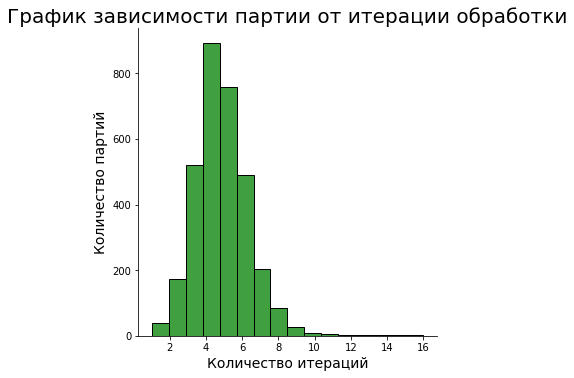

In [5]:
# график
grafic = sns.displot(df_arc['key'].value_counts(), bins=16, color='green')
plt.title('График зависимости партии от итерации обработки', fontsize=20)
plt.xlabel("Количество итераций", fontsize=14)
plt.ylabel("Количество партий", fontsize=14);

Максимальное количество итераций - 16, но таких партий немного. Больше всего партий имеет 4 или 5 итераций.

Можно посмотреть, как распределяются активная и реактивная мощности по партиям.

##### Данные по мощностям

###### Активная мощность

Построим график распределения активной мощности по количеству партий и количеству итераций у них (плотность), а также посмотрим на выбросы на ящике с усами.

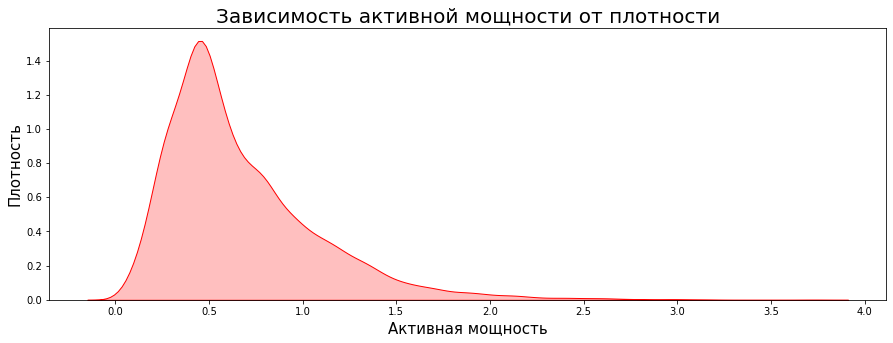

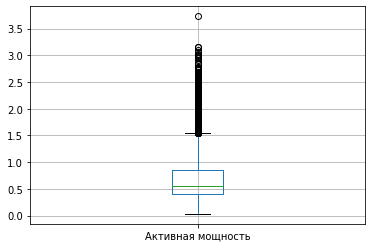

In [6]:
# график
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Активная мощность'],color='r', legend=True,shade=True)
plt.title('Зависимость активной мощности от плотности', fontsize=20)
plt.xlabel("Активная мощность", fontsize=15)
plt.ylabel("Плотность", fontsize=15);
plt.show()
# ящик с усами
fig2 =df_arc.boxplot('Активная мощность')

Видим, что график имеет нормальное распределение со сдвигом влево. Максимальное значение активной мощности 3.731596 выбивается из перечня остальных мощностей. Минимальная мощность - 0.030002. Средняя активная мощность - 0.670441. Медианная - 0.555517.

In [7]:
display(df_arc[df_arc['Активная мощность'] > 3.5])

df_arc[df_arc['key']==1689]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
7799,1689,2019-07-02 18:49:03,2019-07-02 19:04:10,3.731596,2.676388


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
7793,1689,2019-07-02 15:25:34,2019-07-02 15:27:11,0.337803,0.242150
7794,1689,2019-07-02 15:30:19,2019-07-02 15:35:41,1.230050,0.809881
7795,1689,2019-07-02 15:39:06,2019-07-02 15:43:49,1.211215,0.852895
7796,1689,2019-07-02 15:51:04,2019-07-02 15:54:19,0.857824,0.559878
7797,1689,2019-07-02 15:59:13,2019-07-02 16:01:30,0.605553,0.394115
7798,1689,2019-07-02 18:41:20,2019-07-02 18:46:25,1.174942,0.997666
7799,1689,2019-07-02 18:49:03,2019-07-02 19:04:10,3.731596,2.676388
7800,1689,2019-07-02 19:57:33,2019-07-02 20:08:31,2.864100,2.150657
7801,1689,2019-07-02 20:09:54,2019-07-02 20:20:02,2.643099,1.823933
7802,1689,2019-07-02 21:23:27,2019-07-02 21:25:32,0.519904,0.397048


Как кажется, для точности результатов можно удалить партию 1689 из дальнейшего исследования.

Рассмотрим теперь так же данные реактивной мощности.

###### Реактивная мощность

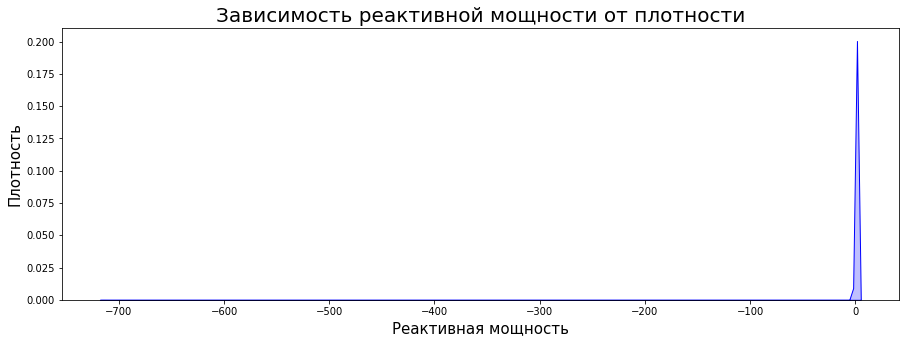

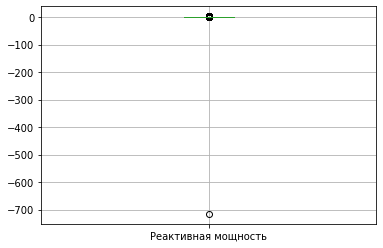

In [8]:
# график
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Реактивная мощность'],color='b', legend=True,shade=True)
plt.title('Зависимость реактивной мощности от плотности', fontsize=20)
plt.xlabel("Реактивная мощность", fontsize=15)
plt.ylabel("Плотность", fontsize=15);
plt.show()
# ящик с усами
fig2 =df_arc.boxplot('Реактивная мощность')

Как уже выше отмечалось, в данных имеются аномальные значения. Минимальная реактивная мощность равна -715.504924, что странно. Видим, что таких отрицательных значений не так много, всего одно.

In [9]:
display(df_arc[df_arc['Реактивная мощность'] < 0])

# срез значений партии 2116
df_arc.query('key == 2116')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Возможно, наличие аномального значения связано с какой-то ошибкой, сделанной либо при измерении, либо при выгрузке данных.

Возможны 2 варианта борбы с аномалией

**Вариант № 1**  
Поскольку значение всего одно, можно избавиться от него, чтобы распределение значений реактивной мощности стало нормальным. Однако в этой партии, в которой обнаружена аномалия, четыре итерации, при удалении одной из итераций данные могут стать недостоверными, поэтому нужно удалять данные всей партии.

**Вариант № 2**  
Нам может не понадобиться для построения модели столбец с данными, в которых найдена аномалия. В этом случае строку с аномалией можно не трогать, так как в итоговый датасет она не попадёт.

**Реализуемый вариант**  
Принимаем решение временно удалить партию с номером 2116, чтобы посмотреть на распределение данных столбца "Реактивная мощность" без аномалии.

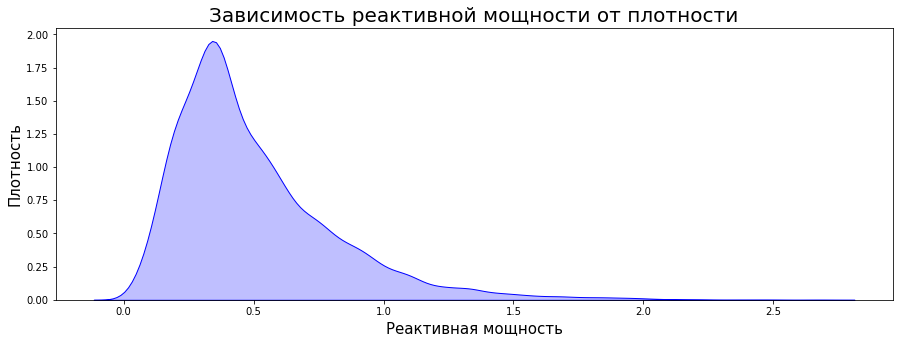

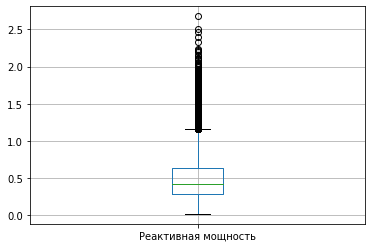

In [10]:
# удаление строк с номером партии 2116
df_arc_variant = df_arc[df_arc['key'] != 2116]

# график
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc_variant['Реактивная мощность'], color='b', legend=True, shade=True)
plt.title('Зависимость реактивной мощности от плотности', fontsize=20)
plt.xlabel("Реактивная мощность", fontsize=15)
plt.ylabel("Плотность", fontsize=15);
plt.show()
# ящик с усами
fig2 =df_arc_variant.boxplot('Реактивная мощность')

In [11]:
df_arc_variant['Реактивная мощность'].describe()

count    14872.000000
mean         0.500763
std          0.310897
min          0.020806
25%          0.291008
50%          0.416280
75%          0.637476
max          2.676388
Name: Реактивная мощность, dtype: float64

Теперь распределение значений стало нормальным и похожим на распределение значений активной мощности (видим такой же сдвиг влево).

Посмотрим на корреляцию значений активной и реактивной мощностей.

<Figure size 1296x720 with 0 Axes>

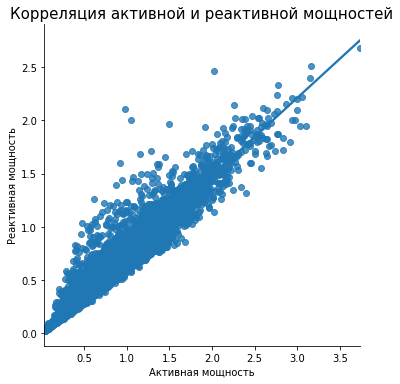

Корреляция активной и реактивной мощности: 0.9631799081909953


In [12]:
#Корреляция активной и реактивной мощностей
plt.figure(figsize=(18,10))
sns.lmplot(x='Активная мощность', y='Реактивная мощность', data=df_arc_variant)
plt.title('Корреляция активной и реактивной мощностей', fontsize=15)
plt.show();
print('Корреляция активной и реактивной мощности:', df_arc_variant['Активная мощность'].corr(df_arc_variant['Реактивная мощность']))

Корреляция между данными очень высокая. Возможно, данные для дальнейшего работы можно объединить либо отказаться, например, от столбца реактивной мощности.

##### Данные о времени

In [13]:
df_arc['Начало нагрева дугой'].sort_values()

0        2019-05-03 11:02:14
1        2019-05-03 11:07:28
2        2019-05-03 11:11:44
3        2019-05-03 11:18:14
4        2019-05-03 11:26:09
                ...         
14871    2019-09-01 03:58:58
14872    2019-09-01 04:05:04
14873    2019-09-01 04:16:41
14874    2019-09-01 04:31:51
14875    2019-09-01 04:34:47
Name: Начало нагрева дугой, Length: 14876, dtype: object

В датафрейме представлены данные с 3 мая по 1 сентября 2019 года.

##### Вывод

<div style="border-radius: 15px; border: 3px solid green; padding: 15px;">

В датафрейме 14876 строк и 5 столбцов: номер партии (key), начало нагрева дуги, конец нагрева дуги, активная мощность, реактивная мощность. Представлены данные, полученные **с 3 мая по 1 сентября 2019 года**.

Всего номеров **партий 3214**. Часть партий имеет больше одной итерации. Максимальное количество итераций - 16, но таких партий немного. Чаще всего партия имеет **4 или 5 итераций**.
    
**Активная мощность**: максимальное значение - 3.731596, минимальное значение - 0.030002, среднее значение - 0.670441, медианное значение - 0.555517.

**Реактивная мощность**: максимальное значение - 2.676388, минимальное значение - 0.020806 (-715.504924 - аномалия), среднее значение - 0.500763, медианное значение - 0.416280.

Активная и реактивная мощности имеют высокую **корреляцию - 0.96**, в связи с чем возможно исключение данных реактивной мощности из дальнейшей работы либо суммирование обоих показателей. В данном случае выбор падает на первый вариант.

**Дубликатов и пропусков** нет.
    
**Аномалии**  
1. Разнотипные названия столбцов.
2. Аномальное значение в столбце "Реактивная мощность" (удалена).

**Причины аномалий**
Возможно, наличие аномального значения связано с какой-то ошибкой, сделанной либо при измерении, либо при выгрузке данных.

**Работа с аномалиями**
1. Разнотипные названия столбцов **приведем к общему виду** при сборе общего датафрема.
    
2. Выше были описаны два варианта работы с аномалией. Поскольку обнаружено, что между столбцами "Активная мощность" и "Реактивная мощность" есть высокая корреляция, принято решение строку с аномалиями, а следовательно, и данные партии 2116 не трогать, а **исключить из дальнейшего исследования данные столбца "Реактивная мощность"**.

**Примечание**
Если всё же данные столбца "Реактивная мощность" понадобятся, необходимо будет убрать из датафрейма все данные партии номера 2116.
    
<hr>    
  
      
**Дальнейшая работа с данными**  
1. Суммировать итерации по каждой партии.
2. Создать столбец с количеством итераций (может быть, понадобится).
3. Убрать из перечня партий партию номера 1689, так в ее данных содержится выброс в столбце "Активная мощность".

#### Данные о легировании стали

##### Данные о подаче сыпучих материалов (объём и время)

###### Общие сведения

Данные о подаче сыпучих материалов содержатся в двух датафреймах df_bulk_vol и df_bulk_time. Рассмотрим каждый из них.

In [14]:
display(open_info(df_bulk_vol))

open_info(df_bulk_time)

*******************************************************
Представление датафрейма


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


*******************************************************
Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
*******************************************************
Распреде

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


*******************************************************
Дубликаты: 0
*******************************************************
Пропуски: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


None

*******************************************************
Представление датафрейма


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


*******************************************************
Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
*******************************************************
Распределение данных


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


*******************************************************
Дубликаты: 0
*******************************************************
Пропуски: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


В датафреймах есть данные по 15 подачам сыпучих материалов (объемы и время) и номера партий. Размер датафреймов и количество пропусков совпадает.  

Рассмотрим отдельные столбцы.

###### Данные о столбцах подачи сыпучих материалов

Очень много пропусков в столбца. Меньше всего пропусков данных при 14 подаче. Всего строк 3129, соответственно, по 2, 5, 7, 8, 9 и 13 подачам почти нет данных (в 8 подаче данные есть только по одной партии). Наличие пропусков может быть связано с тем, что в каждую партию совершаются не все 15 подач. В этом случае на этапе обработки данных можно заполнить пропуски нулевыми значениями.  

Посмотрим, какое количество подач сыпучих материалов приходится на каждую партию.

In [15]:
# создание столбца с количеством подач для каждой партии
df_bulk_vol["sum_bulk"] = 15 - df_bulk_vol.isnull().sum(axis= 1)

df_bulk_vol.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,4
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,4
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,4
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,4
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,4


In [16]:
df_bulk_vol['sum_bulk'].value_counts()

4    1439
5     510
3     500
2     312
1     296
6      71
7       1
Name: sum_bulk, dtype: int64

Минимальное количество подач для одной партии - 1, максимальное - 7.

Больше всего партий, в которых совершается 4 подачи сыпучих материалов, - 1439. Меньше всего партий (1 партия), в которых совешается 7 подач.

In [17]:
# данные партии, в которых совершается 7 подач сыпучих материалов
df_bulk_vol.query('sum_bulk == 7')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
1699,1759,46.0,NaN,212.0,NaN,33.0,121.0,NaN,NaN,NaN,NaN,NaN,410.0,NaN,251.0,205.0,7


###### Данные по key

In [18]:
# количество партий
print('Количество партий:', len(df_bulk_vol['key'].unique()))

df_bulk_vol['key'].value_counts()

Количество партий: 3129


2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

В датафрейме только 3129 партий. В датафрейме df_arc 3214 партий. Следовательно, какие-то номера партий в датафрейме df_bulk_vol отсутствуют. Посмотрим, какие именно. Создадим два списка: один список номеров партии из датафрейма df_arc, другой из датафрейма df_bulk_vol.

In [19]:
# Список key из df_arc
key_arc_list = df_arc['key'].unique().tolist()
print(key_arc_list)
# Список key из df_bulk_vol
key_bulk_list = df_bulk_vol['key'].unique().tolist()
print(key_bulk_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 

Выведем список номеров партий, отсутствующих в датафрейме df_bulk_vol.

In [20]:
result_key_bulk_no = list(set(key_arc_list) - set(key_bulk_list))
print(result_key_bulk_no, 'Количество партий:', len(result_key_bulk_no))

[2056, 1566, 2595, 1062, 2599, 2600, 2608, 51, 52, 53, 54, 55, 56, 2625, 2628, 72, 80, 81, 1105, 1623, 110, 3182, 1656, 3216, 2195, 2196, 661, 2197, 151, 2198, 2216, 2217, 2738, 2739, 2231, 188, 1221, 225, 1268, 1783, 2816, 2821, 2310, 269, 1818, 302, 2863, 1334, 830, 2884, 330, 331, 332, 2891, 2390, 343, 350, 2408, 874, 1911, 1402, 2434, 2460, 931, 2468, 933, 934, 1959, 2471, 1974, 1979, 960, 961, 964, 966, 3018, 3026, 983, 984, 2009, 2010, 3047, 1517, 1518, 2043, 1535] Количество партий: 86


Выведем список номеров партий, отсутствующих в датафрейме df_arc.

In [21]:
result_key_arc_no_1 = list(set(key_bulk_list) - set(key_arc_list))
print(result_key_arc_no_1)

[279]


Таким образом, мы видим, что 86 номеров партий не имеют данных о подаче сыпучих материалов. Т.е., возможно, в этих партиях сталь легируют другим способом - подавая проволоку через специальный трайб-аппарат. Соответственно, данные о них должны содержаться в датафрейме df_wire_vol.

Для номера партии 279 не имеется данных об электродах. Возможно, здесь какая-то ошибка, связанная с выгрузкой данных. В итоговую таблицу данный номер партии не включается.

In [22]:
df_arc.query('key == 279')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


###### Данные о времени

В датафрейме df_bulk_time в столбцах с подачей сыпучих материалов содержатся не объемы материалов, а время подачи. Посмотрим, каким дням работы соответствуют даты в столбцах.

Возьмем данные из столбца, в котором меньше всего пропусков - Bulk 14.

In [23]:
# список с датами
bulk_time_list = df_bulk_time['Bulk 14'].unique().tolist()

# первая дата
display(bulk_time_list[0])

# последняя дата
bulk_time_list[-1]

'2019-05-03 11:03:52'

'2019-09-01 04:05:34'

Как видим, в датафреймах есть данные с 3 мая до 1 сентября 2019 г., что соответствует временному промежутку, обозначенному при анализе данных датафрейма df_arc.

##### Данные о проволочных материалах (объём)

###### Общие сведения

In [24]:
open_info(df_wire_vol)

*******************************************************
Представление датафрейма


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*******************************************************
Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
*******************************************************
Распределение данных


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


*******************************************************
Дубликаты: 0
*******************************************************
Пропуски: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


In [25]:
open_info(df_wire_time)

*******************************************************
Представление датафрейма


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*******************************************************
Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
*******************************************************
Распределение данных


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


*******************************************************
Дубликаты: 0
*******************************************************
Пропуски: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


В датафреймах 3081 строка и 10 столбцов: столбец с номерами партий и 9 столбцов с данными о проволочных материалах (9 разновидностей). Есть пропуски. Меньше всего их в столбце Wire 1 (26), больше всего в столбце Wire 5 (3080).

###### Данные о столбцах подачи проволочных материалов

Как видим, наиболее часто осуществляется подача проволочных материалов типа 1 и 2, остальных намного реже. Как и выше, наличие пропусков может быть связано с тем, что в каждую партию совершаются не все 9 подач. В этом случае на этапе обработки данных можно заполнить пропуски нулевыми значениями.

Посмотрим, какое количество подач проволочных материалов приходится на каждую партию.

In [26]:
# создание столбца с количеством подач для каждой партии
df_wire_vol["sum_wire"] = 9 - df_wire_vol.isnull().sum(axis= 1)

df_wire_vol.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [27]:
df_wire_vol['sum_wire'].value_counts()

1    1936
2    1045
3      88
4       6
5       6
Name: sum_wire, dtype: int64

Минимальное количество подач для одной партии - 1, максимальное - 5.

Больше всего партий, в которых совершается 1 подача проволочных материалов, - 1936. Меньше всего партий (по 6 партий), в которых совешается 5 подач разного проволочного материала.

In [28]:
# данные партии, в которых совершается 5 подач сыпучих материалов
df_wire_vol.query('sum_wire == 5')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
2008,2106,4.06224,NaN,95.375282,113.231044,NaN,68.434087,5.035472,NaN,NaN,5
2009,2107,9.08544,NaN,93.165077,82.150638,NaN,99.219122,8.490040,NaN,NaN,5
2010,2108,11.05104,NaN,93.213127,92.570401,NaN,63.045845,1.053936,NaN,NaN,5
2012,2110,3.10128,NaN,93.165077,56.078880,NaN,91.428487,0.234208,NaN,NaN,5
2435,2562,18.43296,NaN,96.096001,43.020641,NaN,67.438800,11.417641,NaN,NaN,5
2439,2566,2.09664,NaN,95.279190,47.224323,NaN,3.020157,9.134113,NaN,NaN,5


###### Данные по key

In [29]:
# количество партий
print('Количество партий:', len(df_wire_vol['key'].unique()))

df_wire_vol['key'].value_counts()

Количество партий: 3081


2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

В датафрейме только 3081 партий. В датафрейме df_arc 3214 партий. Следовательно, какие-то номера партий в датафрейме df_wire_vol отсутствуют. Посмотрим, какие именно. Создадим список номеров партии из датафрейма df_bulk_vol и сравним его со списком из датафрейма df_arc.

In [30]:
# Список key из df_bulk_vol
key_wire_list = df_wire_vol['key'].unique().tolist()
print(key_wire_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49, 50, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240

Выведем список номеров партий, отсутствующих в датафрейме df_wire_vol.

In [31]:
result_key_wire_no = list(set(key_arc_list) - set(key_wire_list))
print(result_key_wire_no, 'Количество партий:', len(result_key_wire_no))

[1564, 1565, 1566, 51, 52, 53, 54, 55, 56, 2624, 2625, 2626, 2627, 2628, 2629, 1102, 1103, 1104, 1105, 81, 82, 83, 84, 85, 1106, 88, 1107, 109, 1646, 2195, 2196, 2197, 2198, 1184, 2214, 2215, 2216, 2217, 2218, 2219, 2236, 2238, 197, 711, 712, 713, 714, 715, 1743, 1744, 209, 1746, 210, 211, 212, 1747, 1748, 1745, 1758, 2788, 2789, 2790, 2791, 744, 2792, 748, 754, 755, 2814, 2815, 269, 1817, 1818, 796, 797, 798, 799, 800, 2846, 2847, 2848, 2849, 2850, 1836, 2863, 2871, 2360, 2872, 2873, 2874, 2875, 2876, 2367, 2368, 2369, 2370, 841, 330, 331, 332, 2388, 2389, 2390, 2391, 2392, 2393, 1379, 1380, 375, 376, 377, 378, 1946, 929, 930, 931, 932, 933, 934, 1977, 1978, 1979, 2010, 3035, 3036, 3037, 3038, 3039, 3040, 1525, 1526, 1527, 1528, 2043] Количество партий: 134


Выведем список номеров партий, отсутствующих в датафрейме df_arc.

In [32]:
result_key_arc_no_2 = list(set(key_wire_list) - set(key_arc_list))
print(result_key_arc_no_2)

[279]


Тот же номер партии, что был выведен при сравнении списков партий из датафреймов df_arc и df_bulk_vol.

Таким образом, мы видим, что 134 номера партий не имеют данных о подаче проволочных материалов. Т.е., возможно, в этих партиях сталь легируют другим способом - сыпучими материалами. Соответственно, данные о них должны содержаться в датафрейме df_bulk_vol.

Сравним списки.

In [33]:
# выведем список партий, которые отсутствуют и в датафрейме df_wire_vol,
# и в датафрейме df_bulk_vol
result_key_wire_bulk_no = list(set(result_key_wire_no) - set(key_bulk_list))
print(result_key_wire_bulk_no, len(result_key_wire_bulk_no))

[269, 2195, 2196, 2197, 2198, 1818, 1566, 931, 933, 934, 2216, 2217, 2863, 51, 52, 53, 54, 55, 56, 1979, 2625, 2628, 330, 331, 332, 1105, 81, 2390, 2010, 2043] 30


In [34]:
display(df_arc.query('key == 269'))
display(df_bulk_vol.query('key == 269'))
df_wire_vol.query('key == 269')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
1223,269,2019-05-13 10:37:00,2019-05-13 10:39:09,0.425258,0.408596


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire


Таким образом в 30 партиях под номерами 269, 2195, 2196, 2197, 2198, 1818, 1566, 931, 933, 934, 2216, 2217, 2863, 51, 52, 53, 54, 55, 56, 1979, 2625, 2628, 330, 331, 332, 1105, 81, 2390, 2010, 2043 отсутствует какой либо из двух процессов легирования стали. Возможно ли, что сталь миновала этот этап обработки?

In [35]:
display(df_gas.query('key == 269'))
df_temp.query('key == 269')

,key,Газ 1
266,269,2.255418


,key,Время замера,Температура
1506,269,2019-05-13 10:42:47,1612.0
1507,269,2019-05-13 10:45:12,1614.0
1508,269,2019-05-13 10:47:38,1605.0
1509,269,2019-05-13 10:51:01,1595.0


При этом можно заметить, что данные по продувке сплавов и по температуре имеются.

In [36]:
# выведем список партий, которые отсутствуют в датафрейме df_wire_vol,
# но есть в датафрейме df_bulk_vol
result_key_bulk_no_wire = list(set(result_key_wire_no) - set(result_key_wire_bulk_no))
print(result_key_bulk_no_wire, len(result_key_bulk_no_wire))

[1564, 1565, 2624, 2626, 2627, 2629, 1102, 1103, 1104, 82, 83, 84, 85, 1106, 88, 1107, 109, 1646, 1184, 2214, 2215, 2218, 2219, 2236, 2238, 197, 711, 712, 713, 714, 715, 1743, 1744, 209, 210, 1746, 211, 212, 1747, 1748, 1745, 1758, 2788, 2789, 2790, 2791, 744, 2792, 748, 754, 755, 2814, 2815, 1817, 796, 797, 798, 799, 800, 2846, 2847, 2848, 2849, 2850, 1836, 2871, 2360, 2872, 2873, 2874, 2875, 2876, 2367, 2368, 2369, 2370, 841, 2388, 2389, 2391, 2392, 2393, 1379, 1380, 375, 376, 377, 378, 1946, 929, 930, 932, 1977, 1978, 3035, 3036, 3037, 3038, 3039, 3040, 1525, 1526, 1527, 1528] 104


Оставшиеся 104 партии, отсутствующие в датафрейме df_wire_vol, присутствуют в датафрейме df_bulk_vol

In [37]:
# проверка
display(df_arc.query('key == 1564'))
display(df_bulk_vol.query('key == 1564'))
df_wire_vol.query('key == 1564')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
7199,1564,2019-06-28 17:12:33,2019-06-28 17:14:05,0.308734,0.239433
7200,1564,2019-06-28 17:15:47,2019-06-28 17:19:25,0.961726,0.653207
7201,1564,2019-06-28 17:20:36,2019-06-28 17:25:59,1.533105,0.981887
7202,1564,2019-06-28 17:26:53,2019-06-28 17:32:53,1.719741,1.143824
7203,1564,2019-06-28 17:42:34,2019-06-28 17:45:28,0.781040,0.499669


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
1507,1564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,435.0,NaN,198.0,NaN,2


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire


Таким образом, предположение о том, что отсутствующие номера партий в датафрейме df_bulk_vol есть в датафрейме df_wire_vol и наоборот, окозалось верным частично. 30 Номеров партий, данные о которых отсутствуют в датафрейме df_bulk_vol, отсутствуют и в датафрейме df_wire_vol.

Получается, что легирование стали может проходить по трем сценариям:

1) легирование только сыпучими материалами, 2) легирование только проволочными материалами, 3) легирование и сыпучими, проволочными материалами. Либо легирование стали отсутствует вовсе.

In [38]:
# пример партии, в которой легирование стали производится сразу двумя способами
display(df_arc.query('key == 1'))
display(df_bulk_vol.query('key == 1'))
display(df_bulk_time.query('key == 1'))
display(df_wire_vol.query('key == 1'))
df_wire_time.query('key == 1')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,4


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Если смотреть на время легирования тем или иным материалом, то можно отметить, что в партии 1 сначала осуществлялось легирование сыпучими материалами Bulk 12, 14 и 15, затем легирование проволочным материалом Wire 1, а потом еще легирование сыпучим материалом Bulk 4.

###### Данные о времени

В датафрейме df_wire_time в столбцах с подачей проволочных материалов содержатся не объемы материалов, а время подачи. Посмотрим, каким дням работы соответствуют даты в столбцах.

Возьмем данные из столбца, в котором меньше всего пропусков - Wire 1.

In [39]:
# список с датами
wire_time_list = df_wire_time['Wire 1'].unique().tolist()

# первая дата
display(wire_time_list[0])

# последняя дата
wire_time_list[-1]

'2019-05-03 11:11:41'

'2019-09-01 04:16:01'

Как видим, в датафреймах есть данные с 3 мая до 1 сентября 2019 г., что соответствует временному промежутку, обозначенному при анализе данных датафрейма df_arc.

##### Вывод

<div style="border-radius: 15px; border: 3px solid green; padding: 15px;">

В датафреймах df_bulk_vol и df_bulk_time 3129 строк и 16 столбцов: столбец с номерами партий (key) и 15 столбцов с информацией о подаче сыпучих материалов.

В датафреймах df_wire_vol и df_wire_time 3081 строка и 10 столбцов: столбец с номерами партий (key) и 9 столбцов с информацией о о подаче проволочных материалов.

По результатам анализа перечня номеров партий можно сделать вывод, что **легирование стали** проходит по **трем сценариям**:  
1) легирование только сыпучими материалами,  
2) легирование только проволочными материалами,  
3) легирование и сыпучими, и проволочными материалами.  
    
Данные о **30** номерах партий (269, 2195, 2196, 2197, 2198, 1818, 1566, 931, 933, 934, 2216, 2217, 2863, 51, 52, 53, 54, 55, 56, 1979, 2625, 2628, 330, 331, 332, 1105, 81, 2390, 2010, 2043) **отсутствуют** как в датафреймах df_bulk_vol и df_bulk_time, так и в датафреймах df_wire_vol и df_wire_time. Это может свидетельствовать либо о том, что **легирование стали отсутствует** на этих партиях, либо произошла какая-то ошибка при выгрузке данных. 
**Пропуски**  
Очень много пропусков в столбцах с типом подачи сыпучих материалов и типом проволочных материалов. Наличие пропусков может быть связано с тем, что в каждую партию совершаются не все 15 подач (сыпучие материалы) или 9 подач (проволочные матераилы) соответственно.  
**Сыпучие материалы**  
Наиболее часто в партиях встречается подачи сыпучих материалов под номерами 4, 12, 14 и 15, самые редкие подачи под номерами 2, 9, 13. Подача под номером 8 встречается один раз. Минимальное количество подач для одной партии - 1, максимальное - 7. Больше всего партий, в которых совершается 4 подачи сыпучих материалов, - насчитывается 1439 таких партий. Меньше всего партий, в которых совешается 7 подач, - 1 партия.  
**Проволочные материалы**  
Чаще встречает подача проволочных материалов под номером 1, реже всего под номером 5 (всего 1 подача). Минимальное количество подач для одной партии - 1, максимальное - 5. Больше всего партий, в которых совершается 1 подача проволочных материалов, - 1936. Меньше всего партий (по 6 партий), в которых совешается 5 подач разного проволочного материала  

**Дубликатов** нет.  

<hr>
    
**Дальнейшая работа с данными**

1. Если считать, что наличие пропусков связано с тем, что не все 15 типов подач сыпучих материалов и не все 9 типов проволочных материалов совершаются в каждой партии, то на этапе обработки данных можно заменить пропуски нулевыми значениями.
2. Партии под номером 279 не должно оказаться в итоговом наборе партий. По ней нет данных в датафрейме df_arc.
3. Нужно определить с чем связано наличие 30 партий, в которых не осуществлялся ни один из процессов легирования стали. Если причина в ошибке выгрузки данных, то удалить эти номера из итогового датафркйма. Если причина в том, что легирование стали просто может отсутствовать, то сохранить все 30 типов партий, заменив в их строках пропуски нулевыми значениями.
4. Возможно, стоит вывести в отдельный столбец сумму всех легирований стали по каждой партии.

#### Данные о продувке сплавов

##### Общие сведения

In [40]:
open_info(df_gas)

*******************************************************
Представление датафрейма


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


*******************************************************
Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
*******************************************************
Распределение данных


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


*******************************************************
Дубликаты: 0
*******************************************************
Пропуски: key      0
Газ 1    0
dtype: int64


В датафрейме 3239 строк и два столбца: номер партии (key) и объем газа, потраченного на продувку (Газ 1).

##### Данные по key

In [41]:
# количество уникальных номеров партий
display(len(df_gas['key'].unique()))

# выявление повторов партий
df_gas['key'].value_counts()

3239

2049    1
3135    1
3115    1
1070    1
3119    1
       ..
2596    1
549     1
2600    1
553     1
2047    1
Name: key, Length: 3239, dtype: int64

Как видим, в таблице присутствует 3239 уникальных номеров партий. Напомним, что в датафрейме df_arc их было 3214, в датафрейме df_bulk_vol - 3129, в датафрейме df_wire_vol - 3081. Соответственно, для ряда партий данного датафрейма нет данных по мощностям, а для ряда партий нет данных либо по подаче сыпучих материалов, либо по подаче проволочных материалов, либо и тех, и других. Следовательно, на этапе подготовки данных для обучения, нужно будет отобрать только те номера партий, информация по которым есть во всех датафреймах. Здесь мы можем вывести список партий, у которых отсутствует вышеназванная информация.

In [42]:
# Список key из df_gas
key_gas_list = df_gas['key'].unique().tolist()
print(key_gas_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 22

In [43]:
# список партий, отсутствующих в датафрейме df_arc, и их количество
result_key_arc_no_2 = list(set(key_gas_list) - set(key_arc_list))
print(result_key_arc_no_2, 'Количество партий:', len(result_key_arc_no_2))

[3200, 382, 3207, 2446, 529, 1300, 279, 540, 1437, 2469, 41, 42, 683, 2356, 2103, 2491, 195, 2373, 710, 607, 355, 2278, 1133, 2031, 506, 2683, 766] Количество партий: 27


У 27 партий под номерами 3200, 382, 3207, 2446, 529, 1300, 279, 540, 1437, 2469, 41, 42, 683, 2356, 2103, 2491, 195, 2373, 710, 607, 355, 2278, 1133, 2031, 506, 2683, 766 отсутствуют данные об электродах.

In [44]:
# список партий, отсутствующих в датафрейме df_gas, и их количество
result_key_gas_no = list(set(key_arc_list) - set(key_gas_list))
print(result_key_gas_no, 'Количество партий:', len(result_key_gas_no))

[193, 259] Количество партий: 2


У партий под номерами 193 и 259 отсутствуют данные о продувке сплавов.

In [45]:
df_gas.query('key == 193')

,key,Газ 1


Т.е. эти значения мы можем удалить из датафрейма df_arc. Удаляем.

In [46]:
# удаление строк
df_arc_good = df_arc.query('key != [193, 259]')

# проверка
df_arc_good.query('key == 193')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


##### Данные по газу

Пропусков нет, посмотрим, каково распределение газа.

In [47]:
df_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

Минимальное количество газа 0.008, максимальное - 77.99. Среднее значение - 11, медианное - 9.84.

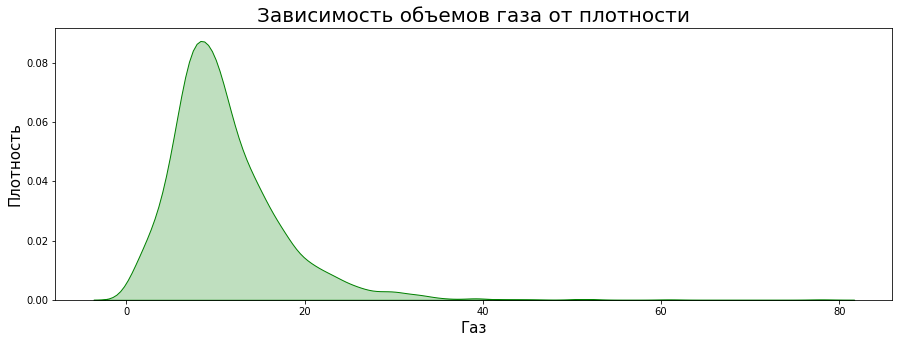

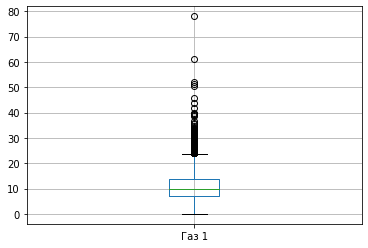

In [48]:
# график
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_gas['Газ 1'],color='g', legend=True,shade=True)
plt.title('Зависимость объемов газа от плотности', fontsize=20)
plt.xlabel("Газ", fontsize=15)
plt.ylabel("Плотность", fontsize=15);
plt.show()
# ящик с усами
fig2 = df_gas.boxplot('Газ 1')

График имеет нормальное распределение со сдвигом влево. Есть небольшие выбросы - два значения, где объем газа больше, чем в остальных случаях. Как кажется, для точности результатов работы лучше данные партий с такими значениями исключить из дальнейшего исследования.

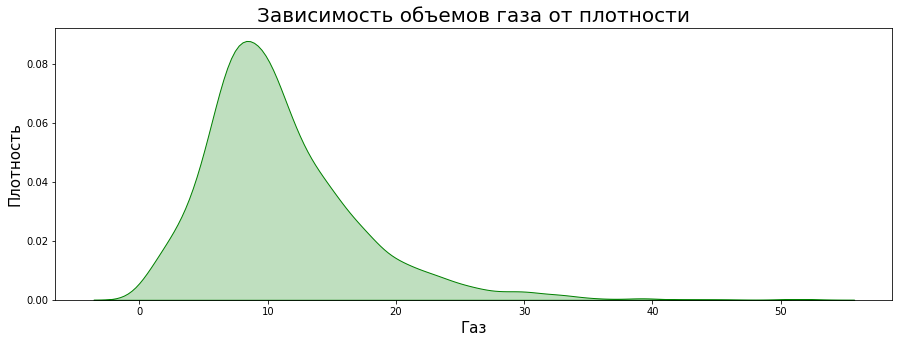

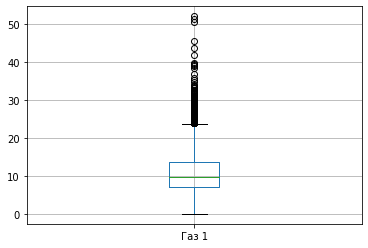

In [49]:
df_gas.loc[df_gas['Газ 1'] >= 60]

df_gas_good = df_gas.loc[df_gas['Газ 1'] < 60]

# график
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_gas_good['Газ 1'],color='g', legend=True,shade=True)
plt.title('Зависимость объемов газа от плотности', fontsize=20)
plt.xlabel("Газ", fontsize=15)
plt.ylabel("Плотность", fontsize=15);
plt.show()
# ящик с усами
fig2 = df_gas_good.boxplot('Газ 1')

Теперь мы видим, что на графике нет сильно выбивающихся значений столбца "Газ 1".

Таким образом, из дальнейшего исследования можно исключить партии под номерами 277 и 319.

In [50]:
df_gas_good['Газ 1'].describe()

count    3237.000000
mean       10.965940
std         6.046293
min         0.008399
25%         7.042268
50%         9.828795
75%        13.767550
max        52.142373
Name: Газ 1, dtype: float64

В этом случае данные по объемам газа следующие: минимальное значение - 0.008, максимальное - 52.14, среднее - 10.96, медианное - 9.83.

##### Вывод

<div style="border-radius: 15px; border: 3px solid green; padding: 15px;">

В датафрейме **3239 строк и 2 столбца**: номер партии (key) и объем газа, потраченного на продувку (Газ 1).

Т.е. в таблице присутствует 3239 уникальных номеров партий. Соответственно, для ряда партий данного датафрейма нет данных по мощностям, а для ряда партий нет данных либо по подаче сыпучих материалов, либо по подаче проволочных материалов, либо и тех, и других.
    
У 27 партий под номерами 3200, 382, 3207, 2446, 529, 1300, 279, 540, 1437, 2469, 41, 42, 683, 2356, 2103, 2491, 195, 2373, 710, 607, 355, 2278, 1133, 2031, 506, 2683, 766 в датафрейме df_gas отсутствуют данные об электродах. У партий под номерами 193 и 259, наоборот, отсутствуют данные о продувке сплавов. Соответственно, все вышеназванные 29 партий исключаются из дальнейшего исследования.

Данные по объемам газа следующие: минимальное значение - 0.008, максимальное - 52.14, среднее - 10.96, медианное - 9.83. Два значения были исключены, поскольку наиболее сильно выбивались из всего перечня значений.

**Пропусков** нет.
    
**Дубликатов** нет. 

#### Результаты измерения температуры

##### Общие сведения

In [51]:
open_info(df_temp)

*******************************************************
Представление датафрейма


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


*******************************************************
Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
*******************************************************
Распределение данных


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


*******************************************************
Дубликаты: 0
*******************************************************
Пропуски: key                0
Время замера       0
Температура     2901
dtype: int64


В датафрейме 15907 строк и 2 столбца: номер партии (key) и температура.

Данные по температурам указаны не для всех партий. Имеется 2901 пропуск. Cтроки с этими пропусками можно сразу удалить, так как адекватно заполнить их не представляется возможным.

Посмотрим, можем ли мы удалить строки только с пропусками.

##### Данные по температуре

In [52]:
# вывод среза данных с пропусками в столбце "Температура"
df_temp_nan = df_temp[df_temp['Температура'].isnull()]

df_temp_nan.head()

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN


In [53]:
display(df_temp.query('key == 2500'))
df_temp.query('key == 2501')

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN


,key,Время замера,Температура
12271,2501,2019-08-06 03:44:42,1587.0
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN


Как видим, удалить строки только с пропусками неудачная идея, поскольку тогда могут остаться данные, не являющиеся конечными. Не получится удостовериться в том, конечная эта температура, промежуточная или начальная. В связи с этим удалять строки нужно по номерам партий, в которых есть пропуски.

Выведем список номеров партий, в данных которых есть пропуски по температурам.

In [54]:
key_temp_nan_list = df_temp_nan['key'].unique().tolist()

print(key_temp_nan_list, 'Количество партий:', len(key_temp_nan_list))

[2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 266

Теперь по этому списку удалим строки в датафрейме df_temp

In [55]:
df_temp_good = df_temp.query('key not in @key_temp_nan_list')

display(df_temp_good.head())

# проверка наличия пропусков
df_temp_good.info()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12267 non-null  int64  
 1   Время замера  12267 non-null  object 
 2   Температура   12267 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 383.3+ KB


Теперь пропусков нет. Построим график и посмотрим на распределение значений.

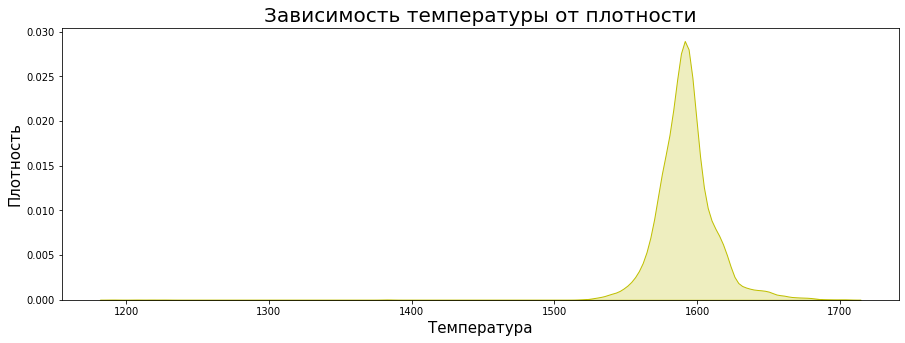

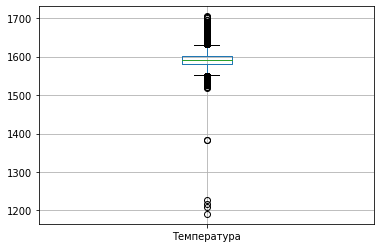

In [56]:
# график
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_temp_good['Температура'],color='y', legend=True,shade=True)
plt.title('Зависимость температуры от плотности', fontsize=20)
plt.xlabel("Температура", fontsize=15)
plt.ylabel("Плотность", fontsize=15);
plt.show()
# ящик с усами
fig2 = df_temp_good.boxplot('Температура')

Распределение значений нормальное.

##### Данные по key

Создадим список номеров партий df_temp_good и сравним его со списком номеров партий из датафрейма df_arc.

In [57]:
len(df_temp_good['key'].unique())

2477

Уникальных номеров партий в df_temp_good 2477, что сильно меньше количества партий в датафрейме df_arc.

In [58]:
# список уникальных номеров партий в df_temp_good (после удаления пропусков)
key_temp_list = df_temp_good['key'].unique().tolist()

# выведем список партий, не входящих в df_temp
result_key_arc_no_3 = list(set(key_arc_list) - set(key_temp_list))
print(result_key_arc_no_3, 'Количество партий в списке:', len(result_key_arc_no_3))

[2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 266

741 партию нужно исключить из дальнейшей работы, поскольку для них отсутствуют данные по температуре.

In [59]:
# удаление строк
df_arc_good = df_arc_good.query('key not in @result_key_arc_no_3')
# проверка
df_arc_good.info()

len(df_arc_good['key'].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11439 entries, 0 to 11448
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   11439 non-null  int64  
 1   Начало нагрева дугой  11439 non-null  object 
 2   Конец нагрева дугой   11439 non-null  object 
 3   Активная мощность     11439 non-null  float64
 4   Реактивная мощность   11439 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 536.2+ KB


2473

Вместо 3214 партий в списке партий датафейма df_arc остается 2473 номера.

На следующем этапе работы с материалом необходимо будет в датафреме df_temp оставить только конечные температуры.

In [60]:
# выведем список партий, не входящих в df_temp, но входящих в датафреймы df_arc и df_gas
result_key_temp_no_1 = list(set(key_temp_list) - set(key_arc_list))
result_key_temp_no_2 = list(set(key_temp_list) - set(key_gas_list))
print(result_key_temp_no_1, result_key_temp_no_2)

[195, 279] [193, 259]


Эти номера партий нужно исключить из датафрейма df_temp перед тем, как искать конечные температуры.

In [61]:
# удаление строк
df_temp_good = df_temp_good.query('key != [193, 195, 259, 279]')
# проверка
df_temp_good.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12255 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12255 non-null  int64  
 1   Время замера  12255 non-null  object 
 2   Температура   12255 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 383.0+ KB


##### Данные о времени замера

Ориентируясь на данные о времени замера, можно сравнить температуру сплава на первом этапе и на последнем. При этом важно, чтобы конечное измерение температуры было позднее, чем любой из этапов, указанных выше.

In [62]:
bad_keys = []
for key in list(df_temp_good['key'].unique()):
    try:
        if (df_temp_good[df_temp_good['key'] == key]['Время замера'].max() < 
            df_arc_good[df_arc_good['key'] == key]['Конец нагрева дугой'].max()):
            bad_keys.append(key)
    except:
        bad_keys.append(key)
print(bad_keys, len(bad_keys))

[11, 38, 43, 51, 64, 69, 73, 81, 177, 179, 180, 182, 185, 213, 216, 220, 222, 267, 271, 293, 296, 297, 321, 325, 326, 444, 445, 448, 453, 456, 470, 471, 472, 491, 535, 562, 586, 587, 588, 590, 592, 593, 596, 616, 638, 641, 704, 731, 733, 741, 757, 786, 869, 870, 874, 878, 928, 929, 932, 934, 997, 1057, 1060, 1152, 1153, 1161, 1232, 1313, 1316, 1341, 1371, 1381, 1402, 1433, 1458, 1461, 1464, 1493, 1505, 1558, 1578, 1618, 1622, 1623, 1624, 1639, 1657, 1683, 1685, 1712, 1713, 1720, 1724, 1811, 1813, 1837, 1872, 1873, 1876, 1946, 1949, 1964, 1966, 1987, 1989, 1990, 1992, 1993, 1994, 2053, 2078, 2138, 2140, 2142, 2143, 2152, 2211, 2221, 2261, 2263, 2265, 2300, 2303, 2389, 2390, 2393, 2398, 2425, 2427, 2451, 2457] 131


Для 131 партии последнее время замера, сделано раньше, чем конец нагрева дугой.

Получается, что в датафрейме df_temp по партии номера 11 представлена не конечная температура, а промежуточная: конец нагрева дугой был в 17:29, а последнее время замера в 17:27. Что-то здесь не так.

##### Вывод

<div style="border-radius: 15px; border: 3px solid green; padding: 15px;">

В датафрейме 15907 строк и 2 столбца: номер партии (key) и температура. Для каждой партии представлены как начальная, так и средняя и конечная температуры.  

**Пропуски**
Данные по температурам указаны не для всех партий. Имеется **2901 пропуск**.
Cтроки с этими пропусками **удалены**, так как адекватно заполнить их не представляется возможным. Пропуски удалены по номерам партий, в которых они были обнаружены.

Уникальных номеров партий в df_temp после удаления пропусков **2473**.
    
**Дубликатов** нет.  

**Аномалии**
Ориентируясь на данные о времени замера, можно сравнить температуру сплава на первом этапе и на последнем. При этом важно, чтобы конечное измерение температуры было позднее, чем любой из этапов, указанных выше. **Для 131 партии последнее время замера, сделано раньше, чем был конец нагрева дугой**.
   
**Причины аномалий**
Возможно, наличие несостыковок во данных по времени связано с какой-то ошибкой, сделанной либо при измерении (не то время зафиксировано), либо при выгрузке данных (потеря данных).

**Работа с аномалиями**
Поскольку такая аномалия может привести к искажению результатов работы, предлагается удалить строки с номерами партий 11, 38, 43, 51, 64, 69, 73, 81, 177, 179, 180, 182, 185, 213, 216, 220, 222, 267, 271, 293, 296, 297, 321, 325, 326, 444, 445, 448, 453, 456, 470, 471, 472, 491, 535, 562, 586, 587, 588, 590, 592, 593, 596, 616, 638, 641, 704, 731, 733, 741, 757, 786, 869, 870, 874, 878, 928, 929, 932, 934, 997, 1057, 1060, 1152, 1153, 1161, 1232, 1313, 1316, 1341, 1371, 1381, 1402, 1433, 1458, 1461, 1464, 1493, 1505, 1558, 1578, 1618, 1622, 1623, 1624, 1639, 1657, 1683, 1685, 1712, 1713, 1720, 1724, 1811, 1813, 1837, 1872, 1873, 1876, 1946, 1949, 1964, 1966, 1987, 1989, 1990, 1992, 1993, 1994, 2053, 2078, 2138, 2140, 2142, 2143, 2152, 2211, 2221, 2261, 2263, 2265, 2300, 2303, 2389, 2390, 2393, 2398, 2425, 2427, 2451, 2457.
    
<hr>    
   
      
**Дальнейшая работа с данными**  
1. Найти конечные температуры по каждой партии (это будет целевой признак).
2. Удалить из итогового датафрейма 131 партию, где происходит вышеназванная аномалия. 

#### Общий вывод

<div style="border-radius: 15px; border: 3px solid green; padding: 15px;">

Проанализировано 7 датафреймов в следующем порядке:
1) df_arc — данные об электродах,  
2) df_bulk_vol, df_bulk_time, df_wire_vol, df_wire_time — данные о подаче сыпучих материалов (объем и время) и данные о проволочных материалах (объем и время),  
3) df_gas — данные о продувке сплава газом,  
4) df_temp — результаты измерения температуры.

Представлены данные, полученные **с 3 мая по 1 сентября 2019 года**.

Отдельные замечания по датафреймам.
    
**Данные об электродах**
Партии имеют как одну, так и больше итераций. Максимальное количество итераций - 16, но таких партий немного. Чаще всего партия имеет **4 или 5 итераций**.

Активная и реактивная мощности имеют высокую **корреляцию - 0.96**, в связи с чем возможно исключение данных реактивной мощности из дальнейшей работы.  
    
**Данные о легировании стали**
По результатам анализа перечня номеров партий можно сделать вывод, что **легирование стали** проходит по **трем сценариям**:  
1) легирование только сыпучими материалами,  
2) легирование только проволочными материалами,  
3) легирование и сыпучими, и проволочными материалами.
    
Сыпучие материалы    
Наиболее часто в партиях встречается подачи сыпучих материалов под номерами 4, 12, 14 и 15, самые редкие подачи под номерами 2, 9, 13. Подача под номером 8 встречается один раз. Минимальное количество подач для одной партии - 1, максимальное - 7. Больше всего партий, в которых совершается 4 подачи сыпучих материалов, - насчитывается 1439 таких партий. Меньше всего партий, в которых совешается 7 подач, - 1 партия.  
    
Проволочные материалы    
Чаще встречает подача проволочных материалов под номером 1, реже всего под номером 5 (всего 1 подача). Минимальное количество подач для одной партии - 1, максимальное - 5. Больше всего партий, в которых совершается 1 подача проволочных материалов, - 1936. Меньше всего партий (по 6 партий), в которых совешается 5 подач разного проволочного материала.
    
**Данные о продувке сплавов**  
Выявлен ряд номеров партий, которые имеют не все данные из технологического процесса. В каких-то случаях в партии не хватает информации об электродах, в каких-то случаях о продувке сплавов. Так, У 27 партий под номерами 3200, 382, 3207, 2446, 529, 1300, 279, 540, 1437, 2469, 41, 42, 683, 2356, 2103, 2491, 195, 2373, 710, 607, 355, 2278, 1133, 2031, 506, 2683, 766 в датафрейме df_gas отсутствуют данные об электродах. У партий под номерами 193 и 259, наоборот, отсутствуют данные о продувке сплавов. Соответственно, все вышеназванные 29 партий исключаются из дальнейшего исследования.

<hr> 
    
**Аномалии и выбросы**
В столбцах со значениями мощностей, объемами газа и температур, проведено исследование значений на предмет нормального распределения и выявления выбросов. Найдено небольшое количество выбросов в столбцах с мощностями (2 значения) и объемами газа (2 значения). Эти данные по номерам партии удалены из исследования.
**Дубликатов** нет.
    
**Пропуски** обнаружены в датафреймах df_bulk_vol, df_bulk_time, df_wire_vol, df_wire_time и 
чески удалены. Исключения составляют 30 номеров партий, в данных которых не хватает информации о легировании стали: 269, 2195, 2196, 2197, 2198, 1818, 1566, 931, 933, 934, 2216, 2217, 2863, 51, 52, 53, 54, 55, 56, 1979, 2625, 2628, 330, 331, 332, 1105, 81, 2390, 2010, 2043.
    
**Проблема № 2**
Выявлена 131 партия, в которых есть несостыковки во времени: последнее время замера температуры (df_temp) сделано раньше, чем закончился процесс нагрева дугой (df_arc). Возможно, наличие несостыковок в данных по времени связано с какой-то ошибкой, сделанной либо при измерении (не то время зафиксировано), либо при выгрузке данных (потеря данных).
    
**Решение проблемы № 1**  
Решить, какова причина отсутствия данных о легировании стали для 30 партий. Если пропуски связаны с ошибкой в выгрузке данных, удалить эти партии из исследования. Если стадия легирования стали может быть пропущена, заполнить пропуски нулевыми значениями.    
    
**Решение проблемы № 2**
Удалить партии с данными номерами.

**Список удаленных номеров партий или тех, что необходимо удалить**.
1. Партия 1689. Причина - аномальное значение в столбце "Активная мощность" (еще не удалена).
2. Партии 269, 2195, 2196, 2197, 2198, 1818, 1566, 931, 933, 934, 2216, 2217, 2863, 51, 52, 53, 54, 55, 56, 1979, 2625, 2628, 330, 331, 332, 1105, 81, 2390, 2010, 2043. Причина - отсутствуют данные по легированию стали (еще не удалены; возможно, не надо).
3. Партия 279 (из столбцов df_burk_vol, df_bulk_time, df_wire_vol, df_wire_time). Причина - не имеется данных об электродах (удалены).
4. Партии 3200, 382, 3207, 2446, 529, 1300, 279, 540, 1437, 2469, 41, 42, 683, 2356, 2103, 2491, 195, 2373, 710, 607, 355, 2278, 1133, 2031, 506, 2683, 766 (из столбцов df_gas). Причина - не имеется данных об электродах (удалены).
5. Партии 193, 259 (из df_arc). Причина - отсутствуют данные о продувке сплавов (удалены).
6. 739 партий (из df_temp), список см. выше. Причина - пропуски в столбце "Температура" (удалены).
7. 741 партия (из df_arc), список см. выше. Причина - отсутствуют данные по температуре (удалены).
8. Партии 11, 38, 43, 51, 64, 69, 73, 81, 177, 179, 180, 182, 185, 213, 216, 220, 222, 267, 271, 293, 296, 297, 321, 325, 326, 444, 445, 448, 453, 456, 470, 471, 472, 491, 535, 562, 586, 587, 588, 590, 592, 593, 596, 616, 638, 641, 704, 731, 733, 741, 757, 786, 869, 870, 874, 878, 928, 929, 932, 934, 997, 1057, 1060, 1152, 1153, 1161, 1232, 1313, 1316, 1341, 1371, 1381, 1402, 1433, 1458, 1461, 1464, 1493, 1505, 1558, 1578, 1618, 1622, 1623, 1624, 1639, 1657, 1683, 1685, 1712, 1713, 1720, 1724, 1811, 1813, 1837, 1872, 1873, 1876, 1946, 1949, 1964, 1966, 1987, 1989, 1990, 1992, 1993, 1994, 2053, 2078, 2138, 2140, 2142, 2143, 2152, 2211, 2221, 2261, 2263, 2265, 2300, 2303, 2389, 2390, 2393, 2398, 2425, 2427, 2451, 2457 (из df_arc). Причина - несостыковки в информации по времени замеров температуры (удаление под вопросом).

### Обработка данных

#### Корректировка состава партий по df_arc и df_temp

1. Принимаем решение удалить 30 партий, по которым нет данных о легировании стали.
2. Партии, в данных которых выявлены несостыковки по времени, тоже удаляем.

##### Данные об электродах

In [63]:
# Удаляем 30 партий с пропусками
df_arc_good = df_arc_good.query('key not in @result_key_wire_bulk_no')
# Удаляем 131 партию с временными аномалиями
df_arc_good = df_arc_good.query('key not in @bad_keys')
# Удаляем партию с выбросами по активной мощности
df_arc_good = df_arc_good.query('key != 1689')

len(df_arc_good['key'].unique())

2318

In [64]:
# Переименование столбцов
df_arc_good.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
# Удаление столбца 'reactive_power'
df_arc_good = df_arc_good.drop('reactive_power', axis = 1)
# Проверка
df_arc_good.head(3)

,key,start_time,end_time,active_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363


In [65]:
# Определим количество итераций нагрева
df_arc_count = df_arc_good.groupby(by = 'key', as_index = False).count()[['key','start_time']]
# Переименование столбцов
df_arc_count.columns = ['key','count_iter']
# Проверка
df_arc_count.head(3)

,key,count_iter
0,1,5
1,2,4
2,3,5


In [66]:
# Группировка по партиям
df_arc_group = df_arc_good.groupby(by = 'key', as_index = False).sum()
# Присоединение столбца с количеством итераций по столбцу 'key'
df_arc_group = df_arc_group.merge(df_arc_count, how='left', on = 'key')
# Проверка
df_arc_group.head(3)

,key,active_power,count_iter
0,1,4.878147,5
1,2,3.052598,4
2,3,2.525882,5


In [67]:
# Перевод столбца 'key' в столбец с индексами
df_arc = pd.pivot_table(df_arc_group, values=['active_power', 'count_iter'], index='key')
# Проверка
df_arc.head(3)

,active_power,count_iter
key,,
1,4.878147,5
2,3.052598,4
3,2.525882,5


Итак, в датафрейме df_arc остаются данные о номерах партий, перемещенные в индексы таблицы, активная мощность и количество итераций.

##### Данные о температурах

Удаляем по списку те же партии, что и удаляли выше из датафрейма df_arc.

In [68]:
# Удаляем 30 партий с пропусками
df_temp_good = df_temp_good.query('key not in @result_key_wire_bulk_no')
# Удаляем 131 партию с временными аномалиями
df_temp_good = df_temp_good.query('key not in @bad_keys')
# Удаляем партию с выбросами по активной мощности
df_temp_good = df_temp_good.query('key != 1689')

len(df_temp_good['key'].unique())

2318

Получаем то же количество партий. Теперь находим время первого замера и последнего. Создаем для этих данных столбцы 'start_temp' и 'end_temp' соответственно.

In [69]:
#сгруппируем по первым и последним значениям
df_temp = df_temp_good.groupby(by ='key').agg(['first', 'last']).reset_index()
df_temp.columns = df_temp.columns.droplevel()
df_temp.columns = ['key', 'start_time', 'end_time','start_temp','end_temp']
df_temp = df_temp[['key','start_temp','end_temp']]

In [70]:
# вывод столбцов с температурами и индексом с номерами партий
df_temp = pd.pivot_table(df_temp, values=['start_temp', 'end_temp'], index='key')

Датафрейм сформирован. Сравним количество партий с количество партий в df_arc (2318)

In [71]:
len(df_temp)

2318

Теперь датафреймы имеют одинаковое количество партий, можно составлять общую таблицу с признаками. Для объединения, кроме названных выше датафреймов, нам потребуются df_bulk_vol, df_wire_vol и df_gas. В каждой таблице преобразуем index в значение столбца key, но сначала переименуем названия столбцов в этих датафреймах.

#### Данные по легированию

##### Данные о подаче сыпучих материалов

In [72]:
# df_bulk
# Перевод столбца key в индекс
df_bulk = df_bulk_vol.set_index('key')

# Переименование столбцов
df_bulk.columns = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
                   'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                   'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'count_bulk']

# Проверка
df_bulk.head(3)

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,count_bulk
key,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,4
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,4
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,4


##### Данные о подаче проволочных материалов

In [73]:
# df_wire
# Перевод столбца key в индекс
df_wire = df_wire_vol.set_index('key')

# Переименование столбцов
df_wire.columns = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
                   'wire_6', 'wire_7', 'wire_8', 'wire_9', 'count_wire']

# Проверка
df_wire.head(3)

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,count_wire
key,,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


#### Данные о продувке сплавов

In [74]:
# df_gas
# Перевод столбца key в индекс
df_gas = df_gas.set_index('key')

# Переименование столбцов
df_gas.columns = ['gas']

# Проверка
df_gas.head(3)

,gas
key,
1,29.749986
2,12.555561
3,28.554793


#### Создание общей таблицы

In [75]:
# Соединение столбцов
df_all = pd.concat([df_arc, df_temp, df_bulk, df_gas, df_wire],
                   axis=1, sort=False)

# Проверка
display(df_all.head())
df_all.info()

,active_power,count_iter,end_temp,start_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,count_wire
key,,,,,,,,,,,,,,,,,,,,,
1,4.878147,5.0,1613.0,1571.0,NaN,NaN,NaN,43.0,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,3.052598,4.0,1602.0,1581.0,NaN,NaN,NaN,73.0,NaN,NaN,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,2.525882,5.0,1599.0,1596.0,NaN,NaN,NaN,34.0,NaN,NaN,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,3.209250,4.0,1625.0,1601.0,NaN,NaN,NaN,81.0,NaN,NaN,...,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,3.347173,4.0,1602.0,1576.0,NaN,NaN,NaN,78.0,NaN,NaN,...,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 1 to 3241
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   active_power  2318 non-null   float64
 1   count_iter    2318 non-null   float64
 2   end_temp      2318 non-null   float64
 3   start_temp    2318 non-null   float64
 4   bulk_1        252 non-null    float64
 5   bulk_2        22 non-null     float64
 6   bulk_3        1298 non-null   float64
 7   bulk_4        1014 non-null   float64
 8   bulk_5        77 non-null     float64
 9   bulk_6        576 non-null    float64
 10  bulk_7        25 non-null     float64
 11  bulk_8        1 non-null      float64
 12  bulk_9        19 non-null     float64
 13  bulk_10       176 non-null    float64
 14  bulk_11       177 non-null    float64
 15  bulk_12       2450 non-null   float64
 16  bulk_13       18 non-null     float64
 17  bulk_14       2806 non-null   float64
 18  bulk_15       2248 non-null 

Получился датафрейм с 3241 строкой и 32 столбца. Есть пропуски во всех столбцах. Нам важен в первую очередь столбец - end_temp, поскольку в этом столбце содержится целевой признак. По конечной температуре можно судить о потреблении электроэнергии. Удалим строки, в которых содержатся пропуски в столбце 'end_temp'.

In [76]:
# удалим строки с пропусками в столбце 'end_time'
df_all = df_all.dropna(subset=['end_temp'])
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2318 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   active_power  2318 non-null   float64
 1   count_iter    2318 non-null   float64
 2   end_temp      2318 non-null   float64
 3   start_temp    2318 non-null   float64
 4   bulk_1        189 non-null    float64
 5   bulk_2        13 non-null     float64
 6   bulk_3        931 non-null    float64
 7   bulk_4        757 non-null    float64
 8   bulk_5        53 non-null     float64
 9   bulk_6        431 non-null    float64
 10  bulk_7        13 non-null     float64
 11  bulk_8        1 non-null      float64
 12  bulk_9        13 non-null     float64
 13  bulk_10       130 non-null    float64
 14  bulk_11       124 non-null    float64
 15  bulk_12       1794 non-null   float64
 16  bulk_13       12 non-null     float64
 17  bulk_14       2040 non-null   float64
 18  bulk_15       1630 non-null 

Теперь в датафрейме 2318 строк, а значит, и 2318 партий. Без пропусков оказываются столбцы 'active_power', 'count_iter', 'end_temp' и 'gas'. Иначе говоря с пропусками остаются столбцы, чье содержание касается легирования стали. В этих столбцах пропуски возможны, их можно заполнить нулевым значением. Кроме того, можно убрать столбец 'wire_8', так как в нем на данный момент не содержится ни одного значения.

Под вопросом остаются столбцы, в которых значений меньше 100: bulk_8 (всего одно значение), wire_7 (4 значения), bulk_13 и wire_4 (12 значений), wire_8, bulk_9, bulk_7 и bulk_2 (13 значений).

In [77]:
# Удаление столбца 'wire_5'
df_all = df_all.drop('wire_5', axis=1)

# Заполнение пропусков нулевым значением
df_all = df_all.fillna(0)

# Проверка
display(df_all.head())
df_all.info()

,active_power,count_iter,end_temp,start_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,count_wire
key,,,,,,,,,,,,,,,,,,,,,
1,4.878147,5.0,1613.0,1571.0,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3.052598,4.0,1602.0,1581.0,0.0,0.0,0.0,73.0,0.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.525882,5.0,1599.0,1596.0,0.0,0.0,0.0,34.0,0.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.209250,4.0,1625.0,1601.0,0.0,0.0,0.0,81.0,0.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,3.347173,4.0,1602.0,1576.0,0.0,0.0,0.0,78.0,0.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,2.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2318 entries, 1 to 2499
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   active_power  2318 non-null   float64
 1   count_iter    2318 non-null   float64
 2   end_temp      2318 non-null   float64
 3   start_temp    2318 non-null   float64
 4   bulk_1        2318 non-null   float64
 5   bulk_2        2318 non-null   float64
 6   bulk_3        2318 non-null   float64
 7   bulk_4        2318 non-null   float64
 8   bulk_5        2318 non-null   float64
 9   bulk_6        2318 non-null   float64
 10  bulk_7        2318 non-null   float64
 11  bulk_8        2318 non-null   float64
 12  bulk_9        2318 non-null   float64
 13  bulk_10       2318 non-null   float64
 14  bulk_11       2318 non-null   float64
 15  bulk_12       2318 non-null   float64
 16  bulk_13       2318 non-null   float64
 17  bulk_14       2318 non-null   float64
 18  bulk_15       2318 non-null 

#### Изменение типа данных

На последнем этапе обработки данных можно изменить тип данных на целочисленные в тех случаях, где это целесообразно.

In [78]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2318 entries, 1 to 2499
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   active_power  2318 non-null   float64
 1   count_iter    2318 non-null   float64
 2   end_temp      2318 non-null   float64
 3   start_temp    2318 non-null   float64
 4   bulk_1        2318 non-null   float64
 5   bulk_2        2318 non-null   float64
 6   bulk_3        2318 non-null   float64
 7   bulk_4        2318 non-null   float64
 8   bulk_5        2318 non-null   float64
 9   bulk_6        2318 non-null   float64
 10  bulk_7        2318 non-null   float64
 11  bulk_8        2318 non-null   float64
 12  bulk_9        2318 non-null   float64
 13  bulk_10       2318 non-null   float64
 14  bulk_11       2318 non-null   float64
 15  bulk_12       2318 non-null   float64
 16  bulk_13       2318 non-null   float64
 17  bulk_14       2318 non-null   float64
 18  bulk_15       2318 non-null 

К целочисленным можно привести данные в следующих столбцах: count_iter, end_temp, все bulk, sum_bulk, все wire и sum_wire

In [79]:
# Изменение типа данных с вещественного на целочисленный
df_all[['count_iter', 'start_temp', 'end_temp',
        'count_bulk', 'count_wire']] = df_all[['count_iter', 'start_temp', 'end_temp',
                                               'count_bulk', 'count_wire']].astype('int')
for i in range(1, 16):
    df_all[f'bulk_{i}'] = df_all[f'bulk_{i}'].astype('int')
for i in range(1, 5):
    df_all[f'wire_{i}'] = df_all[f'wire_{i}'].astype('int')
for i in range(6, 10):
    df_all[f'wire_{i}'] = df_all[f'wire_{i}'].astype('int')
# Провека
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2318 entries, 1 to 2499
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   active_power  2318 non-null   float64
 1   count_iter    2318 non-null   int64  
 2   end_temp      2318 non-null   int64  
 3   start_temp    2318 non-null   int64  
 4   bulk_1        2318 non-null   int64  
 5   bulk_2        2318 non-null   int64  
 6   bulk_3        2318 non-null   int64  
 7   bulk_4        2318 non-null   int64  
 8   bulk_5        2318 non-null   int64  
 9   bulk_6        2318 non-null   int64  
 10  bulk_7        2318 non-null   int64  
 11  bulk_8        2318 non-null   int64  
 12  bulk_9        2318 non-null   int64  
 13  bulk_10       2318 non-null   int64  
 14  bulk_11       2318 non-null   int64  
 15  bulk_12       2318 non-null   int64  
 16  bulk_13       2318 non-null   int64  
 17  bulk_14       2318 non-null   int64  
 18  bulk_15       2318 non-null 

Таким образом, в 34 столбцах 2 столбца с объектными данными, два столбца с вещественными данными, остальные с целочисленными данными.

#### Вывод

<div style="border-radius: 15px; border: 3px solid green; padding: 15px;">
    
Итак, мы обработали данные в следующем порядке.
1. Избавились от партий, в которых нет данных о легировании стали, а также от тех партий, в данных которых выявлены несостыковки по времени.
2. Из датафрейма с результатами измерения времени вычленили два столбца: столбец с начальными температурами и столбец с конечными температурами. В процессе работы было выяснено, что наблюдается три типа ситуации с температурами:
    а) конечная температура выше стартовой;
    б) конечная температура нижи стартовой;
    в) конечная температура и стартовая одинаковы.
Эти наблюдения были оформлены в отдельный столбец с объектными данными.
3. Далее мы переименовали столбцы, которые могли быть необходимы для обучения моделей и объединили все таблицы в одну по индексу, предварительно в индекс был перемещен столбец с партиями.
4. После объединения таблиц количество партий и перечень номеров партий был подредактирован с учетом таких столбцов, как df_temp и df_arc. В результате количество партий составило 2318.
5. Оставшиеся пропуски заполнили нулевыми значениями. В процессе был удален стобец 'wire_5', так как после всех манипуляций со строками и столбцами в нем не было ни одного значения. Под вопросом остались такие столбцы, как bulk_8 (всего одно значение), wire_7 (3 значения), bulk_13 и wire_4 (12 значений), wire_8, bulk_9, bulk_7 и bulk_12 (13 значений). На этапе исследования признаков для моделей, возможно, мы к ним вернемся.
6. На последнем этапе обработки данных были изменены типы значений. Для удобства в 30 столбцах вещественные данные были заменены на целочисленные. Два столбца остались с объектными значениями, два с вещественными.

### Исследование признаков

Выполним оценку мультиколлинеарности и отсутсвие зависимостей между целевым признаком и остальными.

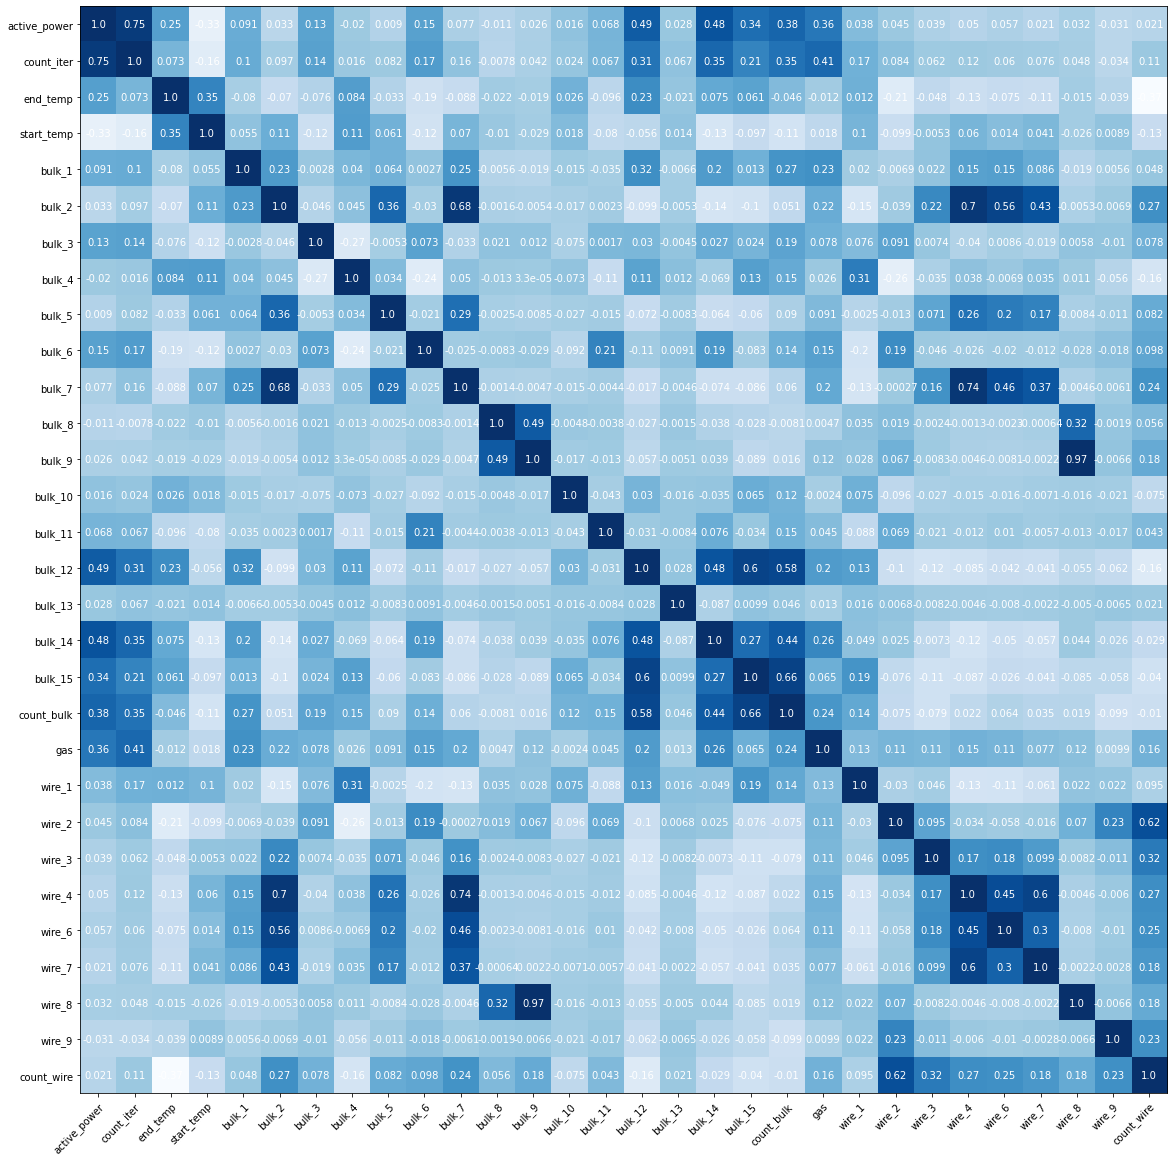

In [80]:
# Хитмеп корреляции признаков 
df_copy = df_all.copy()
heatmap_df = df_copy.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(heatmap_df.index)))
ax.set_yticks(np.arange(len(heatmap_df.index)))

ax.set_xticklabels(heatmap_df.index)
ax.set_yticklabels(heatmap_df.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = heatmap_df.values

for i in range(len(heatmap_df.index)):
    for j in range(len(heatmap_df.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(heatmap_df.corr(), cmap='Blues')

Итак, можно заметить, что наблюдается достаточно высокая корреляция у значений таких столбцов, как wire_8 и bulk_9 - 0.97. Отметим, что в данных столбцах наблюдается одинаковое количество значений. Посмотрим, возможно, эти значения находятся в одних и тех же партиях.

In [81]:
df_all.query('wire_8 != 0 and bulk_9 != 0')

,active_power,count_iter,end_temp,start_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,count_wire
key,,,,,,,,,,,,,,,,,,,,,
280,7.790250,9,1600,1532,0,0,126,0,0,0,...,60.935689,160,76,0,0,0,0,46,0,3
281,4.332464,5,1584,1548,0,0,0,0,0,0,...,34.049878,125,100,0,0,0,0,46,0,3
282,3.877463,5,1587,1560,0,0,80,0,0,0,...,29.641944,90,35,0,0,0,0,46,0,3
283,3.121790,6,1594,1587,0,0,80,0,0,0,...,18.167295,125,35,0,0,0,0,46,0,3
284,3.957187,5,1600,1566,0,0,0,0,0,0,...,10.585429,105,65,0,0,0,0,46,0,3
285,3.701892,6,1594,1565,0,0,92,0,0,0,...,22.733117,60,0,0,0,0,0,46,0,2
286,3.431684,6,1602,1586,0,0,60,0,0,0,...,12.487324,110,45,0,0,0,0,46,0,3
287,2.225473,5,1589,1593,0,0,90,0,0,0,...,28.806377,130,60,0,0,0,0,45,0,3
288,2.345235,5,1584,1585,0,0,83,75,0,0,...,22.368817,70,0,0,0,0,0,45,0,2


Как можно убедиться, все 13 значений находятся в одних и тех же партиях. На основании всего этого можно принять решение удалить из исследования один из столбцов или оба, так как значений мало.

In [82]:
df_all.query('wire_8 != 0 and bulk_9 != 0')['count_wire'].value_counts()
df_all.query('wire_8 != 0 and bulk_9 != 0')['count_bulk'].value_counts()

4    7
3    4
5    2
Name: count_bulk, dtype: int64

Видим, что в этих партиях есть подачи других сыпучих материалов. На этом основании удалим оба столбца.

Удалим и столбец bulk_8, так как в нем всего одно значение.

В списке столбцов, в которых мало значений, остаются столбцы wire_7, bulk_13, wire_4, bulk_7, bulk_2. Рассмотрим каждый из них.

In [83]:
df_all.query('wire_7 != 0')['count_wire'].value_counts()

5    3
Name: count_wire, dtype: int64

Видим, что в строках, в которых есть подача проволочного материала wire_7 есть еще 4 других подачи, следовательно, так как значений всего три, удаляем этот столбец тоже.

In [84]:
df_all.query('bulk_13 != 0')['count_bulk'].value_counts()

4    5
5    3
3    2
6    2
Name: count_bulk, dtype: int64

bulk_13 удаляем тоже, так как значений мало и в строках с этой подачей есть другие подачи.

In [85]:
df_all.query('wire_4 != 0')['count_wire'].value_counts()

5    4
3    3
4    3
2    2
Name: count_wire, dtype: int64

wire_4 удаляем.

In [86]:
df_all.query('bulk_7 != 0')['count_bulk'].value_counts()

5    8
1    3
6    2
Name: count_bulk, dtype: int64

bulk_7 не удаляем по той же причине.

In [87]:
df_all.query('bulk_2 != 0')['count_bulk'].value_counts()

5    7
4    3
2    2
6    1
Name: count_bulk, dtype: int64

bulk_2 удаляем.

Таким образом, из тех столбцов, где мало данных, удаляем столбцы wire_8, bulk_9, bulk_8, wire_7, bulk_13 и bulk_2.

Проверим остальные столбцы сыпучих и проволочных материалов на предмет того, одни они участвуют в легировании или нет. Если не одни, то, возможно, удалим такие столбцы тоже.

In [88]:
# Срез данных с одной подачей сыпучих материалов
df_exp = df_all.query('count_bulk == 1')
# Проверка столбцов с сыпучими материалами по условию
for i in range(1, 16):
    if sum(df_exp[f'bulk_{i}']) == 0:
        print(f'bulk_{i}', 'не может быть единственной в партии')
    if sum(df_exp[f'bulk_{i}']) > 0:
        print(f'bulk_{i}', 'может быть единственной в партии')

bulk_1 не может быть единственной в партии
bulk_2 не может быть единственной в партии
bulk_3 может быть единственной в партии
bulk_4 может быть единственной в партии
bulk_5 может быть единственной в партии
bulk_6 может быть единственной в партии
bulk_7 может быть единственной в партии
bulk_8 не может быть единственной в партии
bulk_9 не может быть единственной в партии
bulk_10 может быть единственной в партии
bulk_11 не может быть единственной в партии
bulk_12 может быть единственной в партии
bulk_13 не может быть единственной в партии
bulk_14 может быть единственной в партии
bulk_15 не может быть единственной в партии


Таким образом, мы можем удалить из дальнейшей работы столбцы bulk_1, bulk_2, bulk_8, bulk_9, bulk_11, bulk_13, bulk_15. Эти подачи материалов не встречаются отдельно в партиях, только в сочетании с другими подачами.

Проверим, сколько партий, в которых подачи встречаются по одному разу.

In [89]:
df_all.query('bulk_3 != 0')['count_bulk'].value_counts()
df_all.query('bulk_4 != 0')['count_bulk'].value_counts()
df_all.query('bulk_5 != 0')['count_bulk'].value_counts() # всего 1 партия
df_all.query('bulk_6 != 0')['count_bulk'].value_counts()
df_all.query('bulk_7 != 0')['count_bulk'].value_counts()
df_all.query('bulk_10 != 0')['count_bulk'].value_counts()
df_all.query('bulk_12 != 0')['count_bulk'].value_counts()
df_all.query('bulk_14 != 0')['count_bulk'].value_counts()

4    1040
5     370
3     343
2     194
6      52
1      40
7       1
Name: count_bulk, dtype: int64

Подача bulk_5 встречается 1 раз, соответственно, можно тоже удалить столбец с ней.

Проверим теперь столбцы wire.

In [90]:
# Срез данных с одной подачей сыпучих материалов
df_exp = df_all.query('count_wire == 1')
# Проверка столбцов с сыпучими материалами по условию
for i in [1, 2, 3, 4, 6, 7, 8, 9]:
    if sum(df_exp[f'wire_{i}']) == 0:
        print(f'wire_{i}', 'не может быть единственной в партии')
    if sum(df_exp[f'wire_{i}']) > 0:
        print(f'wire_{i}', 'может быть единственной в партии')

wire_1 может быть единственной в партии
wire_2 может быть единственной в партии
wire_3 не может быть единственной в партии
wire_4 не может быть единственной в партии
wire_6 может быть единственной в партии
wire_7 не может быть единственной в партии
wire_8 не может быть единственной в партии
wire_9 может быть единственной в партии


Видим, что можно удалить стобцы wire_3, wire_4, wire_7 и wire_8.

In [91]:
df_all.query('wire_1 != 0')['count_wire'].value_counts()
df_all.query('wire_2 != 0')['count_wire'].value_counts()
df_all.query('wire_6 != 0')['count_wire'].value_counts()
df_all.query('wire_9 != 0')['count_wire'].value_counts() # 1 раз

3    23
2     2
1     1
Name: count_wire, dtype: int64

Подачу wire_9 тоже удаляем.

In [92]:
# Удаление столбцов
df_all = df_copy.drop(['wire_3', 'wire_4', 'wire_7', 'wire_8', 'wire_9', 'bulk_1', 'bulk_2', 'bulk_5', 'bulk_8', 'bulk_9', 'bulk_11', 'bulk_13', 'bulk_15'], axis=1)

### Обучение моделей

Для обучения моделей обработаем категориальные признаки и создадим переменные для признаков и целевого признака.

In [93]:
# Обработка категориальных признаков
df_ohe = pd.get_dummies(df_all, drop_first=True)

# Создание переменных для признаков и целевого признака
target = df_ohe['end_temp']
features = df_ohe.drop(['end_temp'], axis=1)

Создадим тренировочную и тестовую выборку в соотношении 75 (тренировочные данные) / 25 (тестовые данные)

In [94]:
# Создание выборок
features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=12345)

features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1738, 16), (580, 16), (1738,), (580,))

In [95]:
# Вывод списка столбцов
features_train.columns

Index(['active_power', 'count_iter', 'start_temp', 'bulk_3', 'bulk_4',
       'bulk_6', 'bulk_7', 'bulk_10', 'bulk_12', 'bulk_14', 'count_bulk',
       'gas', 'wire_1', 'wire_2', 'wire_6', 'count_wire'],
      dtype='object')

После сделаем масштабирование численных признаков (30 признаков из 32)

In [96]:
# Масштабирование численных признаков
numeric = ['active_power', 'count_iter', 'start_temp', 'bulk_3', 'bulk_4',
           'bulk_6', 'bulk_7', 'bulk_10', 'bulk_12', 'bulk_14',
           'count_bulk', 'gas', 'wire_1', 'wire_2', 'wire_6', 'count_wire']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display('Обучающая выборка:', features_train.shape)
display('Тестовая выборка:', features_test.shape)

features_train.head()

'Обучающая выборка:'

(1738, 16)

'Тестовая выборка:'

(580, 16)

,active_power,count_iter,start_temp,bulk_3,bulk_4,bulk_6,bulk_7,bulk_10,bulk_12,bulk_14,count_bulk,gas,wire_1,wire_2,wire_6,count_wire
key,,,,,,,,,,,,,,,,
1610,-0.139586,-0.996414,-1.171388,-0.611748,-0.614259,1.529503,-0.071205,-0.226997,-0.518151,1.780520,0.379108,0.262131,-1.526922,0.212423,-0.112069,1.049029
402,0.432051,0.861041,-1.239857,-0.611748,2.219055,-0.396481,-0.071205,-0.226997,0.010242,-0.027875,0.379108,-0.461347,-0.096716,-0.522666,-0.112069,-0.590550
1570,1.450245,0.861041,-0.794806,-0.611748,-0.614259,-0.396481,-0.071205,-0.226997,1.639983,2.339695,-0.383496,0.202342,-0.725140,1.241547,-0.112069,1.049029
349,-0.721083,0.241890,0.574584,-0.611748,-0.614259,2.692361,-0.071205,-0.226997,-0.308067,-0.634638,0.379108,0.930064,-0.486772,-0.522666,-0.112069,1.049029
201,0.642256,0.861041,-0.041641,-0.611748,1.239638,-0.396481,-0.071205,-0.226997,0.003875,0.721657,1.141713,0.305900,-0.811819,-0.522666,-0.112069,-0.590550


#### Модель LinearRegression

In [97]:
%%time

model_LR = LinearRegression()
MAE_LR_train = (cross_val_score(model_LR, features_train, target_train, cv=5, 
                          scoring='neg_mean_absolute_error').mean()*(-1))
print('MAE of LinearRegression: {:.2f}'.format(MAE_LR_train))

MAE of LinearRegression: 7.54
CPU times: user 152 ms, sys: 67.4 ms, total: 219 ms
Wall time: 178 ms


#### Модель CatBoostRegressor

In [98]:
%%time

model_cat = CatBoostRegressor(verbose=False, random_state=12345)
MAE_cat_train = (cross_val_score(model_cat, features_train, target_train, cv=5,
                           scoring='neg_mean_absolute_error').mean()*(-1))
print('MAE of CatBoostRegressor: {:.2f}'.format(MAE_cat_train))

MAE of CatBoostRegressor: 6.16
CPU times: user 15.6 s, sys: 524 ms, total: 16.2 s
Wall time: 23.2 s


На тренировочной выборке среднее MAE модели CatBoostRegressor составило 6.16. Попробуем подобрать лучшие параметры для модели CatBoostRegressor и посмотрим, каким будет MAE с лучшими параметрами.

In [99]:
# Подбор лучших параметров
best_params_cat = CatBoostRegressor(verbose=False, random_state=12345).fit(features_train,
                                                            target_train).get_all_params()
best_params_cat

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 12345,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04467900097370148,
 'score_function': 'Cosine',
 'task_t

In [100]:
%%time

model_cat_best = CatBoostRegressor(verbose=False)
model_cat_best.set_params(**best_params_cat)
model_cat_best.fit(features_train, target_train)
predict = model_cat_best.predict(features_train)
MAE_CBR_best = mean_absolute_error(predict, target_train)
print('MAE of CatBoostRegressor: {:.2f}'.format(MAE_CBR_best))

MAE of CatBoostRegressor: 3.01
CPU times: user 3.25 s, sys: 115 ms, total: 3.36 s
Wall time: 4.69 s


MAE на тренировочной выборке модели CatBoostRegressor с лучшими параметрами составило 3.01. Протестируем модели на тестовой выборке.

### Тестирование моделей

#### Модель LinearRegression

In [101]:
%%time

model_LR.fit(features_train, target_train)
predict = model_LR.predict(features_test)
MAE_LR_test = mean_absolute_error(predict, target_test)
print('MAE of LinearRegression: {:.2f}'.format(MAE_LR_test))

MAE of LinearRegression: 7.50
CPU times: user 52.8 ms, sys: 60.2 ms, total: 113 ms
Wall time: 88.5 ms


#### Модель CatBoostRegressor

In [102]:
%%time
model_cat = CatBoostRegressor(verbose=False)
model_cat.set_params(**best_params_cat)
model_cat.fit(features_train, target_train)
predict = model_cat.predict(features_test)
MAE_CBR_test = mean_absolute_error(predict, target_test)
print('MAE of CatBoostRegressor: {:.2f}'.format(MAE_CBR_test))

MAE of CatBoostRegressor: 5.99
CPU times: user 3.19 s, sys: 103 ms, total: 3.29 s
Wall time: 4.51 s


#### Вывод

Итак, мы обучили две модели LinearRegression и CatBoostRegressor на 16 признаках. Финальное тестирование моделей показало, что лучше обучается модель CatBoostRegressor. Модель показала результат МАЕ 5.99 на тестовой выборке. Это соответствует условию решения задачи.

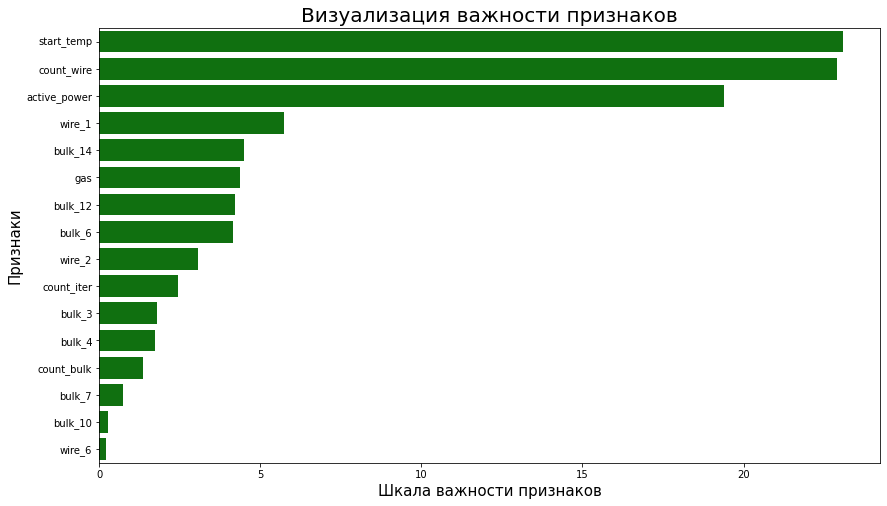

In [103]:
feature_imp = pd.Series(model_cat.feature_importances_, index=features_test.columns).sort_values(ascending=False)
plt.figure(figsize=(14, 8))
fig = sns.barplot(x=feature_imp, y=feature_imp.index, color='g')
plt.title('Визуализация важности признаков', fontsize=20)
plt.xlabel('Шкала важности признаков', fontsize=15)
plt.ylabel('Признаки', fontsize=15);
plt.show()

График показывает, что самыми важными признаками для модели CatBoostRegressor оказываются 'start_temp', 'count_wire' и 'active_power'. Слабозначимыми являются 'wire_6' и 'bulk_10'

# Отчет о проделанной работе
 
 **1. Все пункты плана выполнены.** Данные загружены, обработаны, проанализированы. Определен целевой признак для обучения модели, подобраны признаки. Выбранные модели обучены и протестированы.
 
 Для работы были предоставлены семь датафреймов, но работа велась в основном с пятью из них. Данные из таблиц со временем подачи материалов для легирования почти не использовались, но на первоначальном этапе были проанализированы. Использованные датафреймы:
 
- `df_arc` — данные об электродах;
- `df_bulk` — данные о подаче сыпучих материалов (объём);
- `df_gas` — данные о продувке сплава газом;
- `df_temp` — результаты измерения температуры;
- `df_wire` — данные о проволочных материалах (объём).

**2. Возникшие трудности.**
1) **Разнотипные наименования столбцов** (столбцы были приведены к общему виду в итоговом датафрейме).  
2) Из датафреймов **не получилось собрать всю информацию по каждой встречающейся партии**, так как обнаружилость отсутствие данных об электродах для ряда партий или не хватило данных по температуре (в результате в итоговый датафрейм попали только те партии, которые не имели пропусков по электродам, продувке сплава газом и стартовой и конечной температуре; кроме того, стоит отметить, что из работы были исключены партии без данных о легировании (отсутствие данных по сыпучим и проволочным материалам)).  
3) Обнаружились **факты несоответствия во времени** сделанных измерений: последнее время замера температуры (df_temp) сделано раньше, чем закончился процесс нагрева дугой (df_arc) (такие партии были удалены из исследования).  
4) **Пропуски** (заменены нулевыми значениями в столбцах с сыпучими и проволочными материалами; в остальных случаях партии с пропусками удалялись).  
5) **Создание единого датафрейма** (таблицы объединялись по номерам партий).  
6) **Создание новых столбцов** с данными для исследования:  
    1. столбец с количеством итераций (включен в признаки);  
    2. столбец со стартовой температурой (включен в признаки);  
    3. столбец с конечной температурой (включен в признаки);  
    4. столбец с количеством подач сыпучих материалов (включен в признаки);  
    5. столбец с количеством подач проволочных материалов (включен в признаки).
    
В результате модели обучались на следующих 16 признаках:

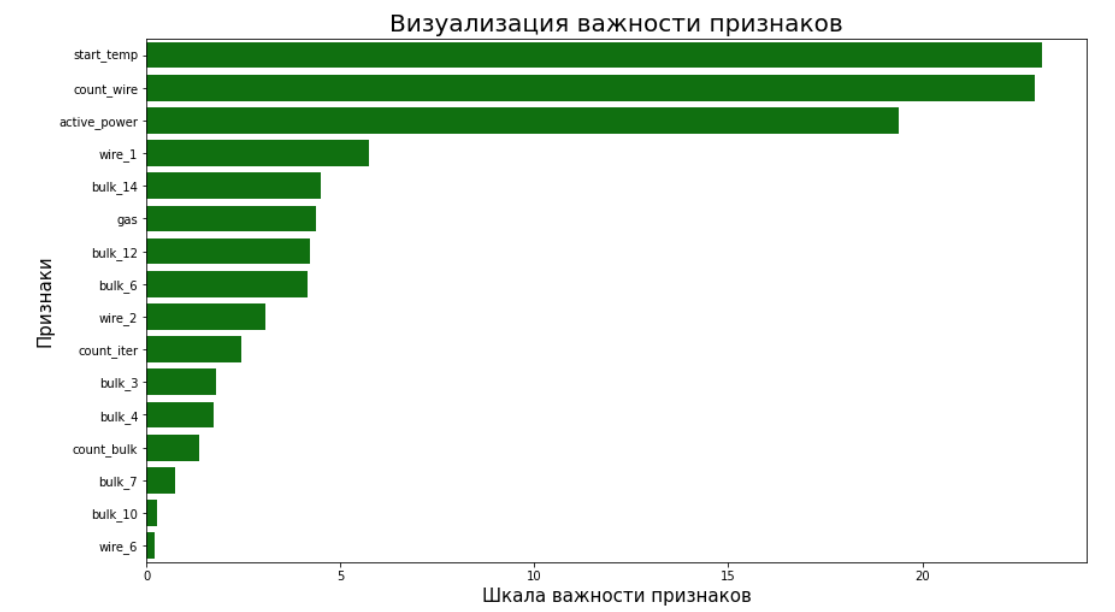

Фактор dif_temp (я его убрала все-таки из работы) мы не сможем в дальнейшем использовать при предсказании температуры конечной, но мы можем использовать этот фактор для анализа и выведения списка условий, которые нужно соблюсти, чтобы достичь той или иной температуры. Но в целом для дальнейшего ввода фактора в модель, которая, например, могла бы предсказать температуру, этот фактор не подходит, но может, наверно, помочь на подготовительном этапе. 

Если идти по другому пути, то можно было бы прямо восстановить весь путь обработки стали (время по всем этапам у нас есть).
Берем, например, делим данные на три группы, где конечная температура выше стартовой, где ниже, а где равна. Дальше можно смотреть, какие сыпучие материалы добавляли, в каком объеме, какой материал за каким шел и выявлять закономерности. Тогда столбец dif_temp помогает весь материал разделить на три группы и посмотреть, какие факторы приводят к снижению стартовой температуры, какие к ее повышению, а какие сохраняют ее уровень. Можем понять, где это случайность, а где закономерность. И таким образом, возможно, наверно, построить как бы все однотипные модели обработки стали, которые должны привести к тому или иному итогу по энергопотреблению.

Вообще, возможно, dif_temp сыграла, потому что надо как-то лучше проследить итерации по каждой партии. Возможно, стоило вывести дополнительные столбцы по температурам на промежуточном этапе.

**Ключевые шаги в решении задачи**
1. Знакомство с предоставленными данными, анализ их пропуски, выбросы, аномалии.
2. Знакомство с технологическим процессом, чтобы составить представление о том, как все работает, какие данные из какого этапа процесса и т.п.
3. Обработка данных с учетом полученных сведений.
4. Выделение целевого признака.
5. Анализ остальных признаков, их корреляции между собой.
6. Подбор возможных моделей, их обучение и тестирование.

В итоге лучшей моделью по метрике MAE = 5.99 на тестовой выборке стала модель CatBoostRegressor. Этот результат показывает, что модель может ошибаться на 6 градусов.